In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
file_path_1 = '/content/drive/MyDrive/Colab Notebooks/minors_pitching_advanced.csv'
file_path_2 = '/content/drive/MyDrive/Colab Notebooks/minors_pitching_profile.csv'
file_path_3 = '/content/drive/MyDrive/Colab Notebooks/minors_pitching_standard.csv'

mpitching1 = pd.read_csv(file_path_1)
mpitching2 = pd.read_csv(file_path_2)
mpitching3 = pd.read_csv(file_path_3)

mpitching4 = pd.merge(mpitching3, mpitching2.drop(columns = ['Name', 'Age', 'IP']), on=['PlayerId', 'Season', 'Team', 'Level'], how='inner')
mpitching = pd.merge(mpitching4, mpitching1.drop(columns = ['Name', 'Age', 'IP', 'BABIP', 'ERA']), on=['PlayerId', 'Season', 'Team', 'Level'], how='inner')

mpitching = mpitching[~((mpitching['IP'] == 0) | (mpitching['IP'].isna()))]
mpitching = mpitching[~((mpitching['Pitches'] == 0) | (mpitching['Pitches'].isna()))]
mpitching = mpitching.sort_values(by='Pitches', ascending=True)

mpitching['BF'] = mpitching['BB'] / mpitching['BB%']

print(mpitching.columns)

Index(['Season', 'Name', 'Team', 'Level', 'Age', 'W', 'L', 'ERA', 'G', 'GS',
       'CG', 'ShO', 'SV', 'BS', 'HLD', 'IP', 'TBF', 'H', 'R', 'ER', 'HR', 'BB',
       'IBB', 'HBP', 'WP', 'BK', 'SO', 'PlayerId', 'BABIP', 'GB/FB', 'LD%',
       'GB%', 'FB%', 'IFFB%', 'HR/FB', 'Pull%', 'Cent%', 'Oppo%', 'SwStr%',
       'Balls', 'Strikes', 'Pitches', 'K/9', 'BB/9', 'K/BB', 'HR/9', 'K%',
       'BB%', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'FIP', 'E-F', 'xFIP', 'BF'],
      dtype='object')


In [3]:
file_path_1 = '/content/drive/MyDrive/Colab Notebooks/minors_batting_advanced.csv'
file_path_2 = '/content/drive/MyDrive/Colab Notebooks/minors_batting_profile.csv'
file_path_3 = '/content/drive/MyDrive/Colab Notebooks/minors_batting_standard.csv'

mbatting1 = pd.read_csv(file_path_1)
mbatting2 = pd.read_csv(file_path_2)
mbatting3 = pd.read_csv(file_path_3)

mbatting4 = pd.merge(mbatting3, mbatting2.drop(columns = ['Name', 'Age', 'PA']), on=['PlayerId', 'Season', 'Team', 'Level'], how='inner')
mbatting = pd.merge(mbatting4, mbatting1.drop(columns = ['Name', 'Age', 'BABIP', 'PA', 'AVG']), on=['PlayerId', 'Season', 'Team', 'Level'], how='inner')

mbatting = mbatting[~((mbatting['PA'] == 0) | (mbatting['PA'].isna()))]
print(mbatting.columns)

Index(['Season', 'Name', 'Team', 'Level', 'Age', 'G', 'AB', 'PA', 'H', '1B',
       '2B', '3B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH',
       'GDP', 'SB', 'CS', 'AVG', 'PlayerId', 'BABIP', 'GB/FB', 'LD%', 'GB%',
       'FB%', 'IFFB%', 'HR/FB', 'Pull%', 'Cent%', 'Oppo%', 'SwStr%', 'Balls',
       'Strikes', 'Pitches', 'BB%', 'K%', 'BB/K', 'OBP', 'SLG', 'OPS', 'ISO',
       'Spd', 'wSB', 'wRC', 'wRAA', 'wOBA', 'wRC+'],
      dtype='object')


In [4]:
file_path_1 = '/content/drive/MyDrive/Colab Notebooks/stats_MLB_batter_2007_2024.csv'
file_path_2 = '/content/drive/MyDrive/Colab Notebooks/stats_MLB_pitchers_2007_2024.csv'

majorsbatting = pd.read_csv(file_path_1)
majorspitching = pd.read_csv(file_path_2)

temp = majorsbatting['last_name, first_name'].str.split(', ', expand=True)
temp.columns = ['last', 'first']
majorsbatting['Name'] = temp['first'] + " " + temp['last']
majorsbatting['Name'] = majorsbatting['Name'].str.rstrip()
majorsbatting['FirstYear'] = majorsbatting.groupby('Name')['year'].transform('min')
majorsbatting = majorsbatting[majorsbatting['year'] == majorsbatting['FirstYear']]

majorsbatting = pd.merge(mbatting, majorsbatting, left_on='Name', right_on='Name', how='inner')
majorsbatting = majorsbatting[majorsbatting['Season'] <= majorsbatting['FirstYear']]


temp = majorspitching['last_name, first_name'].str.split(', ', expand=True)
temp.columns = ['last', 'first']
majorspitching['Name'] = temp['first'] + " " + temp['last']
majorspitching['Name'] = majorspitching['Name'].str.rstrip()
firstyear = majorspitching.groupby('Name')['year'].min().reset_index()
majorspitching['FirstYear'] = majorspitching.groupby('Name')['year'].transform('min')
majorspitching = majorspitching[majorspitching['year'] == majorspitching['FirstYear']]

majorspitching = pd.merge(mpitching, majorspitching, left_on='Name', right_on='Name', how='inner')
majorspitching = majorspitching[majorspitching['Season'] <= majorspitching['FirstYear']]

print(majorspitching.columns)

Index(['Season', 'Name', 'Team', 'Level', 'Age', 'W', 'L', 'ERA', 'G', 'GS',
       'CG', 'ShO', 'SV', 'BS', 'HLD', 'IP', 'TBF', 'H', 'R', 'ER', 'HR', 'BB',
       'IBB', 'HBP', 'WP', 'BK', 'SO', 'PlayerId', 'BABIP', 'GB/FB', 'LD%',
       'GB%', 'FB%', 'IFFB%', 'HR/FB', 'Pull%', 'Cent%', 'Oppo%', 'SwStr%',
       'Balls', 'Strikes', 'Pitches', 'K/9', 'BB/9', 'K/BB', 'HR/9', 'K%',
       'BB%', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'FIP', 'E-F', 'xFIP', 'BF',
       'last_name, first_name', 'player_id', 'year', 'pa', 'k_percent',
       'bb_percent', 'woba', 'xwoba', 'sweet_spot_percent',
       'barrel_batted_rate', 'hard_hit_percent', 'avg_best_speed',
       'avg_hyper_speed', 'whiff_percent', 'swing_percent', 'FirstYear'],
      dtype='object')


In [5]:
# add whether getting to major league

In [6]:
file_path_1 = '/content/drive/MyDrive/Colab Notebooks/MLB Pitching Advanced.csv'
file_path_2 = '/content/drive/MyDrive/Colab Notebooks/MLB Pitching Profile.csv'
file_path_3 = '/content/drive/MyDrive/Colab Notebooks/MLB Pitching Standard.csv'
file_path_4 = '/content/drive/MyDrive/Colab Notebooks/MLB Pitcher Age.csv'

mpitching1 = pd.read_csv(file_path_1)
mpitching2 = pd.read_csv(file_path_2)
mpitching3 = pd.read_csv(file_path_3)
mpitching5 = pd.read_csv(file_path_4)

mpitching4 = pd.merge(mpitching3, mpitching2.drop(columns = ['Name', 'NameASCII', 'MLBAMID']), on=['PlayerId', 'Season', 'Team'], how='inner')
pitching = pd.merge(mpitching4, mpitching1.drop(columns = ['Name', 'BABIP', 'ERA', 'NameASCII', 'MLBAMID']), on=['PlayerId', 'Season', 'Team'], how='inner')
pitching = pd.merge(pitching, mpitching5.drop(columns = ['NameASCII', 'PlayerId', 'MLBAMID']), on=['Name', 'Season', 'Team'], how='inner')

pitching = pitching[~((pitching['Pitches'] == 0) | (pitching['Pitches'].isna()))]
pitching = pitching.sort_values(by='Pitches', ascending=True)

print(pitching.columns)

Index(['Season', 'Name', 'Team', 'W', 'L', 'ERA', 'G', 'GS', 'QS', 'CG', 'ShO',
       'SV', 'HLD', 'BS', 'IP', 'TBF', 'H', 'R', 'ER', 'HR', 'BB', 'IBB',
       'HBP', 'WP', 'BK', 'SO', 'NameASCII', 'PlayerId', 'MLBAMID', 'BABIP',
       'GB/FB', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'RS', 'RS/9', 'Balls',
       'Strikes', 'Pitches', 'Pull%', 'Cent%', 'Oppo%', 'Soft%', 'Med%',
       'Hard%', 'K/9', 'BB/9', 'K/BB', 'HR/9', 'K%', 'BB%', 'K-BB%', 'AVG',
       'WHIP', 'LOB%', 'ERA-', 'FIP-', 'xFIP-', 'FIP', 'E-F', 'xFIP', 'SIERA',
       'Age'],
      dtype='object')


In [7]:
file_path_1 = '/content/drive/MyDrive/Colab Notebooks/MLB Batting Advanced.csv'
file_path_2 = '/content/drive/MyDrive/Colab Notebooks/MLB Batting Profile.csv'
file_path_3 = '/content/drive/MyDrive/Colab Notebooks/MLB Batting Standard.csv'
file_path_4 = '/content/drive/MyDrive/Colab Notebooks/MLB Batter Age.csv'

mbatting1 = pd.read_csv(file_path_1)
mbatting2 = pd.read_csv(file_path_2)
mbatting3 = pd.read_csv(file_path_3)
mbatting5 = pd.read_csv(file_path_4)

mbatting4 = pd.merge(mbatting3, mbatting2.drop(columns = ['Name', 'NameASCII', 'MLBAMID']), on=['PlayerId', 'Season', 'Team'], how='inner')
batting = pd.merge(mbatting4, mbatting1.drop(columns = ['Name', 'BABIP', 'AVG', 'PA', 'NameASCII', 'MLBAMID']), on=['PlayerId', 'Season', 'Team'], how='inner')
batting = pd.merge(batting, mbatting5.drop(columns = ['NameASCII', 'PlayerId', 'MLBAMID']), on=['Name', 'Season', 'Team'], how='inner')

batting = batting[~((batting['PA'] == 0) | (batting['PA'].isna()))]
print(batting.columns)

Index(['Season', 'Name', 'Team', 'G', 'AB', 'PA', 'H', '1B', '2B', '3B', 'HR',
       'R', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH', 'GDP', 'SB', 'CS',
       'AVG', 'NameASCII', 'PlayerId', 'MLBAMID', 'BABIP', 'GB/FB', 'LD%',
       'GB%', 'FB%', 'IFFB%', 'HR/FB', 'IFH', 'IFH%', 'BUH', 'BUH%', 'Pull%',
       'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%', 'BB%', 'K%', 'BB/K', 'OBP',
       'SLG', 'OPS', 'ISO', 'Spd', 'UBR', 'wGDP', 'XBR', 'wSB', 'wRC', 'wRAA',
       'wOBA', 'wRC+', 'Age'],
      dtype='object')


In [8]:
mpitching['H%'] = mpitching.apply(lambda row: row['H'] / row['TBF'] if row['H'] > 0 else 0, axis=1)
mpitching['Ball%'] = mpitching.apply(lambda row: row['Balls'] / row['Pitches'] if row['Balls'] > 0 else 0, axis=1)
mpitching['Strike%'] = mpitching.apply(lambda row: row['Strikes'] / row['Pitches'] if row['Strikes'] > 0 else 0, axis=1)
mpitching['HR%'] = mpitching.apply(lambda row: row['HR'] / row['TBF'] if row['HR'] > 0 else 0, axis=1)

pitching['H%'] = pitching.apply(lambda row: row['H'] / row['TBF'] if row['H'] > 0 else 0, axis=1)
pitching['Ball%'] = pitching.apply(lambda row: row['Balls'] / row['Pitches'] if row['Balls'] > 0 else 0, axis=1)
pitching['Strike%'] = pitching.apply(lambda row: row['Strikes'] / row['Pitches'] if row['Strikes'] > 0 else 0, axis=1)
pitching['HR%'] = pitching.apply(lambda row: row['HR'] / row['TBF'] if row['HR'] > 0 else 0, axis=1)

print(mpitching.columns)

Index(['Season', 'Name', 'Team', 'Level', 'Age', 'W', 'L', 'ERA', 'G', 'GS',
       'CG', 'ShO', 'SV', 'BS', 'HLD', 'IP', 'TBF', 'H', 'R', 'ER', 'HR', 'BB',
       'IBB', 'HBP', 'WP', 'BK', 'SO', 'PlayerId', 'BABIP', 'GB/FB', 'LD%',
       'GB%', 'FB%', 'IFFB%', 'HR/FB', 'Pull%', 'Cent%', 'Oppo%', 'SwStr%',
       'Balls', 'Strikes', 'Pitches', 'K/9', 'BB/9', 'K/BB', 'HR/9', 'K%',
       'BB%', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'FIP', 'E-F', 'xFIP', 'BF', 'H%',
       'Ball%', 'Strike%', 'HR%'],
      dtype='object')


In [9]:
pitching21 = pitching[pitching['Age'] == 21]
pitching21 = pitching21.drop(columns = ['Season', 'W', 'L', 'G', 'GS', 'QS', 'CG', 'ShO', 'SV', 'HLD', 'BS', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'WP', 'BK', 'SO', 'NameASCII',
       'PlayerId', 'MLBAMID', 'GB/FB', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'RS', 'RS/9', 'Balls', 'Strikes', 'Pitches', 'Pull%', 'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%', 'K/9', 'BB/9',
       'K/BB', 'HR/9', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'ERA-', 'FIP-', 'xFIP-', 'FIP', 'E-F', 'xFIP', 'SIERA', 'Age'])
pitching21 = pitching21.rename(columns={'ERA': 'ERA21', 'TBF': 'TBF21', 'BABIP': 'BABIP21', 'K%': 'K%21', 'BB%': 'BB%21', 'H%': 'H%21', 'Ball%': 'Ball%21', 'Strike%': 'Strike%21',
                                        'HR%': 'HR%21'})
pitching22 = pitching[pitching['Age'] == 22]
pitching22 = pitching22.drop(columns = ['Season', 'W', 'L', 'G', 'GS', 'QS', 'CG', 'ShO', 'SV', 'HLD', 'BS', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'WP', 'BK', 'SO', 'NameASCII',
       'PlayerId', 'MLBAMID', 'GB/FB', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'RS', 'RS/9', 'Balls', 'Strikes', 'Pitches', 'Pull%', 'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%', 'K/9', 'BB/9',
       'K/BB', 'HR/9', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'ERA-', 'FIP-', 'xFIP-', 'FIP', 'E-F', 'xFIP', 'SIERA', 'Age'])
pitching22 = pitching22.rename(columns={'ERA': 'ERA22', 'TBF': 'TBF22', 'BABIP': 'BABIP22', 'K%': 'K%22', 'BB%': 'BB%22', 'H%': 'H%22', 'Ball%': 'Ball%22', 'Strike%': 'Strike%22',
                                        'HR%': 'HR%22'})
pitching23 = pitching[pitching['Age'] == 23]
pitching23 = pitching23.drop(columns = ['Season', 'W', 'L', 'G', 'GS', 'QS', 'CG', 'ShO', 'SV', 'HLD', 'BS', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'WP', 'BK', 'SO', 'NameASCII',
       'PlayerId', 'MLBAMID', 'GB/FB', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'RS', 'RS/9', 'Balls', 'Strikes', 'Pitches', 'Pull%', 'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%', 'K/9', 'BB/9',
       'K/BB', 'HR/9', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'ERA-', 'FIP-', 'xFIP-', 'FIP', 'E-F', 'xFIP', 'SIERA', 'Age'])
pitching23 = pitching23.rename(columns={'ERA': 'ERA23', 'TBF': 'TBF23', 'BABIP': 'BABIP23', 'K%': 'K%23', 'BB%': 'BB%23', 'H%': 'H%23', 'Ball%': 'Ball%23', 'Strike%': 'Strike%23',
                                        'HR%': 'HR%23'})
pitching24 = pitching[pitching['Age'] == 24]
pitching24 = pitching24.drop(columns = ['Season', 'W', 'L', 'G', 'GS', 'QS', 'CG', 'ShO', 'SV', 'HLD', 'BS', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'WP', 'BK', 'SO', 'NameASCII',
       'PlayerId', 'MLBAMID', 'GB/FB', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'RS', 'RS/9', 'Balls', 'Strikes', 'Pitches', 'Pull%', 'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%', 'K/9', 'BB/9',
       'K/BB', 'HR/9', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'ERA-', 'FIP-', 'xFIP-', 'FIP', 'E-F', 'xFIP', 'SIERA', 'Age'])
pitching24 = pitching24.rename(columns={'ERA': 'ERA24', 'TBF': 'TBF24', 'BABIP': 'BABIP24', 'K%': 'K%24', 'BB%': 'BB%24', 'H%': 'H%24', 'Ball%': 'Ball%24', 'Strike%': 'Strike%24',
                                        'HR%': 'HR%24'})
pitching25 = pitching[pitching['Age'] == 25]
pitching25 = pitching25.drop(columns = ['Season', 'W', 'L', 'G', 'GS', 'QS', 'CG', 'ShO', 'SV', 'HLD', 'BS', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'WP', 'BK', 'SO', 'NameASCII',
       'PlayerId', 'MLBAMID', 'GB/FB', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'RS', 'RS/9', 'Balls', 'Strikes', 'Pitches', 'Pull%', 'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%', 'K/9', 'BB/9',
       'K/BB', 'HR/9', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'ERA-', 'FIP-', 'xFIP-', 'FIP', 'E-F', 'xFIP', 'SIERA', 'Age'])
pitching25 = pitching25.rename(columns={'ERA': 'ERA25', 'TBF': 'TBF25', 'BABIP': 'BABIP25', 'K%': 'K%25', 'BB%': 'BB%25', 'H%': 'H%25', 'Ball%': 'Ball%25', 'Strike%': 'Strike%25',
                                        'HR%': 'HR%25'})
pitching26 = pitching[pitching['Age'] == 26]
pitching26 = pitching26.drop(columns = ['Season', 'W', 'L', 'G', 'GS', 'QS', 'CG', 'ShO', 'SV', 'HLD', 'BS', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'WP', 'BK', 'SO', 'NameASCII',
       'PlayerId', 'MLBAMID', 'GB/FB', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'RS', 'RS/9', 'Balls', 'Strikes', 'Pitches', 'Pull%', 'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%', 'K/9', 'BB/9',
       'K/BB', 'HR/9', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'ERA-', 'FIP-', 'xFIP-', 'FIP', 'E-F', 'xFIP', 'SIERA', 'Age'])
pitching26 = pitching26.rename(columns={'ERA': 'ERA26', 'TBF': 'TBF26', 'BABIP': 'BABIP26', 'K%': 'K%26', 'BB%': 'BB%26', 'H%': 'H%26', 'Ball%': 'Ball%26', 'Strike%': 'Strike%26',
                                        'HR%': 'HR%26'})
pitching27 = pitching[pitching['Age'] == 27]
pitching27 = pitching27.drop(columns = ['Season', 'W', 'L', 'G', 'GS', 'QS', 'CG', 'ShO', 'SV', 'HLD', 'BS', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'WP', 'BK', 'SO', 'NameASCII',
       'PlayerId', 'MLBAMID', 'GB/FB', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'RS', 'RS/9', 'Balls', 'Strikes', 'Pitches', 'Pull%', 'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%', 'K/9', 'BB/9',
       'K/BB', 'HR/9', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'ERA-', 'FIP-', 'xFIP-', 'FIP', 'E-F', 'xFIP', 'SIERA', 'Age'])
pitching27 = pitching27.rename(columns={'ERA': 'ERA27', 'TBF': 'TBF27', 'BABIP': 'BABIP27', 'K%': 'K%27', 'BB%': 'BB%27', 'H%': 'H%27', 'Ball%': 'Ball%27', 'Strike%': 'Strike%27',
                                        'HR%': 'HR%27'})
pitching28 = pitching[pitching['Age'] == 28]
pitching28 = pitching28.drop(columns = ['Season', 'W', 'L', 'G', 'GS', 'QS', 'CG', 'ShO', 'SV', 'HLD', 'BS', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'WP', 'BK', 'SO', 'NameASCII',
       'PlayerId', 'MLBAMID', 'GB/FB', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'RS', 'RS/9', 'Balls', 'Strikes', 'Pitches', 'Pull%', 'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%', 'K/9', 'BB/9',
       'K/BB', 'HR/9', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'ERA-', 'FIP-', 'xFIP-', 'FIP', 'E-F', 'xFIP', 'SIERA', 'Age'])
pitching28 = pitching28.rename(columns={'ERA': 'ERA28', 'TBF': 'TBF28', 'BABIP': 'BABIP28', 'K%': 'K%28', 'BB%': 'BB%28', 'H%': 'H%28', 'Ball%': 'Ball%28', 'Strike%': 'Strike%28',
                                        'HR%': 'HR%28'})
pitching29 = pitching[pitching['Age'] == 29]
pitching29 = pitching29.drop(columns = ['Season', 'W', 'L', 'G', 'GS', 'QS', 'CG', 'ShO', 'SV', 'HLD', 'BS', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'WP', 'BK', 'SO', 'NameASCII',
       'PlayerId', 'MLBAMID', 'GB/FB', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'RS', 'RS/9', 'Balls', 'Strikes', 'Pitches', 'Pull%', 'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%', 'K/9', 'BB/9',
       'K/BB', 'HR/9', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'ERA-', 'FIP-', 'xFIP-', 'FIP', 'E-F', 'xFIP', 'SIERA', 'Age'])
pitching29 = pitching29.rename(columns={'ERA': 'ERA29', 'TBF': 'TBF29', 'BABIP': 'BABIP29', 'K%': 'K%29', 'BB%': 'BB%29', 'H%': 'H%29', 'Ball%': 'Ball%29', 'Strike%': 'Strike%29',
                                        'HR%': 'HR%29'})
pitching30 = pitching[pitching['Age'] == 30]
pitching30 = pitching30.drop(columns = ['Season', 'W', 'L', 'G', 'GS', 'QS', 'CG', 'ShO', 'SV', 'HLD', 'BS', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'WP', 'BK', 'SO', 'NameASCII',
       'PlayerId', 'MLBAMID', 'GB/FB', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'RS', 'RS/9', 'Balls', 'Strikes', 'Pitches', 'Pull%', 'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%', 'K/9', 'BB/9',
       'K/BB', 'HR/9', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'ERA-', 'FIP-', 'xFIP-', 'FIP', 'E-F', 'xFIP', 'SIERA', 'Age'])
pitching30 = pitching30.rename(columns={'ERA': 'ERA30', 'TBF': 'TBF30', 'BABIP': 'BABIP30', 'K%': 'K%30', 'BB%': 'BB%30', 'H%': 'H%30', 'Ball%': 'Ball%30', 'Strike%': 'Strike%30',
                                        'HR%': 'HR%30'})

mpitching = pd.get_dummies(mpitching, columns=['Level'], drop_first=True)
mpitching = mpitching.fillna(0)

pitching21 = pd.merge(mpitching, pitching21, on = ['Name', 'Team'], how='right')
pitching22 = pd.merge(mpitching, pitching22, on = ['Name', 'Team'], how='right')
pitching23 = pd.merge(mpitching, pitching23, on = ['Name', 'Team'], how='right')
pitching24 = pd.merge(mpitching, pitching24, on = ['Name', 'Team'], how='right')
pitching25 = pd.merge(mpitching, pitching25, on = ['Name', 'Team'], how='right')
pitching26 = pd.merge(mpitching, pitching26, on = ['Name', 'Team'], how='right')
pitching27 = pd.merge(mpitching, pitching27, on = ['Name', 'Team'], how='right')
pitching28 = pd.merge(mpitching, pitching28, on = ['Name', 'Team'], how='right')
pitching29 = pd.merge(mpitching, pitching29, on = ['Name', 'Team'], how='right')
pitching30 = pd.merge(mpitching, pitching30, on = ['Name', 'Team'], how='right')

pitching21 = pitching21[pitching21['Age'] <= 21]
pitching22 = pitching22[pitching22['Age'] <= 22]
pitching23 = pitching23[pitching23['Age'] <= 23]
pitching24 = pitching24[pitching24['Age'] <= 24]
pitching25 = pitching25[pitching25['Age'] <= 25]
pitching26 = pitching26[pitching26['Age'] <= 26]
pitching27 = pitching27[pitching27['Age'] <= 27]
pitching28 = pitching28[pitching28['Age'] <= 28]
pitching29 = pitching29[pitching29['Age'] <= 29]
pitching30 = pitching30[pitching30['Age'] <= 30]

print(pitching21.columns)

Index(['Season', 'Name', 'Team', 'Age', 'W', 'L', 'ERA', 'G', 'GS', 'CG',
       'ShO', 'SV', 'BS', 'HLD', 'IP', 'TBF', 'H', 'R', 'ER', 'HR', 'BB',
       'IBB', 'HBP', 'WP', 'BK', 'SO', 'PlayerId', 'BABIP', 'GB/FB', 'LD%',
       'GB%', 'FB%', 'IFFB%', 'HR/FB', 'Pull%', 'Cent%', 'Oppo%', 'SwStr%',
       'Balls', 'Strikes', 'Pitches', 'K/9', 'BB/9', 'K/BB', 'HR/9', 'K%',
       'BB%', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'FIP', 'E-F', 'xFIP', 'BF', 'H%',
       'Ball%', 'Strike%', 'HR%', 'Level_A+', 'Level_A-', 'Level_AA',
       'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R', 'ERA21', 'TBF21',
       'BABIP21', 'K%21', 'BB%21', 'H%21', 'Ball%21', 'Strike%21', 'HR%21'],
      dtype='object')


In [10]:
def aggregate_by_player(df):
    def weighted_avg(sub_df, col):
        return (sub_df[col] * sub_df["TBF"]).sum() / sub_df["TBF"].sum()

    agg_funcs = {col: (lambda sub_df, c=col: weighted_avg(sub_df, c)) for col in df.columns if col not in ["PlayerId", "TBF"]}
    agg_funcs["TBF"] = lambda sub_df: sub_df["TBF"].sum()

    return df.groupby("PlayerId", as_index=False).apply(lambda g: pd.Series({col: func(g) for col, func in agg_funcs.items()}))

In [11]:
mpitching.fillna(0, inplace=True)
mpitching = mpitching[mpitching['TBF'] > 0]

mpitching17 = mpitching[mpitching['Age'] == 17]
mpitching17 = mpitching17.drop(columns = ['Season', 'Name', 'Team', 'Age', 'W', 'L', 'G', 'GS', 'CG', 'ShO', 'SV', 'BS', 'HLD', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'WP', 'BK',
       'SO', 'HR/FB', 'Balls', 'Strikes', 'Pitches', 'K/9', 'BB/9', 'K/BB', 'HR/9', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'FIP', 'E-F', 'xFIP', 'BF', 'GB/FB', 'Strike%', 'Oppo%', 'IFFB%'])
mpitching17DSL = mpitching17[mpitching17['Level_DSL'] == True]
mpitching17DSL = mpitching17DSL.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching17CPX = mpitching17[mpitching17['Level_CPX'] == True]
mpitching17CPX = mpitching17CPX.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching17R = mpitching17[mpitching17['Level_R'] == True]
mpitching17R = mpitching17R.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching17LowA = mpitching17[mpitching17['Level_A-'] == True]
mpitching17LowA = mpitching17LowA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching17A = mpitching17[mpitching17['Level_A+'] == True]
mpitching17A = mpitching17A.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching17AA = mpitching17[mpitching17['Level_AA'] == True]
mpitching17AA = mpitching17AA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching17AAA = mpitching17[mpitching17['Level_AAA'] == True]
mpitching17AAA = mpitching17AAA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])

mpitching18 = mpitching[mpitching['Age'] == 18]
mpitching18 = mpitching18.drop(columns = ['Season', 'Name', 'Team', 'Age', 'W', 'L', 'G', 'GS', 'CG', 'ShO', 'SV', 'BS', 'HLD', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'WP', 'BK',
       'SO', 'HR/FB', 'Balls', 'Strikes', 'Pitches', 'K/9', 'BB/9', 'K/BB', 'HR/9', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'FIP', 'E-F', 'xFIP', 'BF', 'GB/FB', 'Strike%', 'Oppo%', 'IFFB%'])
mpitching18DSL = mpitching18[mpitching18['Level_DSL'] == True]
mpitching18DSL = mpitching18DSL.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching18CPX = mpitching18[mpitching18['Level_CPX'] == True]
mpitching18CPX = mpitching18CPX.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching18R = mpitching18[mpitching18['Level_R'] == True]
mpitching18R = mpitching18R.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching18LowA = mpitching18[mpitching18['Level_A-'] == True]
mpitching18LowA = mpitching18LowA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching18A = mpitching18[mpitching18['Level_A+'] == True]
mpitching18A = mpitching18A.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching18AA = mpitching18[mpitching18['Level_AA'] == True]
mpitching18AA = mpitching18AA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching18AAA = mpitching18[mpitching18['Level_AAA'] == True]
mpitching18AAA = mpitching18AAA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])

# For Age 19
mpitching19 = mpitching[mpitching['Age'] == 19]
mpitching19 = mpitching19.drop(columns = ['Season', 'Name', 'Team', 'Age', 'W', 'L', 'G', 'GS', 'CG', 'ShO', 'SV', 'BS', 'HLD', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'WP', 'BK',
       'SO', 'HR/FB', 'Balls', 'Strikes', 'Pitches', 'K/9', 'BB/9', 'K/BB', 'HR/9', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'FIP', 'E-F', 'xFIP', 'BF', 'GB/FB', 'Strike%', 'Oppo%', 'IFFB%'])
mpitching19DSL = mpitching19[mpitching19['Level_DSL'] == True]
mpitching19DSL = mpitching19DSL.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching19CPX = mpitching19[mpitching19['Level_CPX'] == True]
mpitching19CPX = mpitching19CPX.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching19R = mpitching19[mpitching19['Level_R'] == True]
mpitching19R = mpitching19R.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching19LowA = mpitching19[mpitching19['Level_A-'] == True]
mpitching19LowA = mpitching19LowA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching19A = mpitching19[mpitching19['Level_A+'] == True]
mpitching19A = mpitching19A.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching19AA = mpitching19[mpitching19['Level_AA'] == True]
mpitching19AA = mpitching19AA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching19AAA = mpitching19[mpitching19['Level_AAA'] == True]
mpitching19AAA = mpitching19AAA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])

# For Age 20
mpitching20 = mpitching[mpitching['Age'] == 20]
mpitching20 = mpitching20.drop(columns = ['Season', 'Name', 'Team', 'Age', 'W', 'L', 'G', 'GS', 'CG', 'ShO', 'SV', 'BS', 'HLD', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'WP', 'BK',
       'SO', 'HR/FB', 'Balls', 'Strikes', 'Pitches', 'K/9', 'BB/9', 'K/BB', 'HR/9', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'FIP', 'E-F', 'xFIP', 'BF', 'GB/FB', 'Strike%', 'Oppo%', 'IFFB%'])
mpitching20DSL = mpitching20[mpitching20['Level_DSL'] == True]
mpitching20DSL = mpitching20DSL.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching20CPX = mpitching20[mpitching20['Level_CPX'] == True]
mpitching20CPX = mpitching20CPX.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching20R = mpitching20[mpitching20['Level_R'] == True]
mpitching20R = mpitching20R.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching20LowA = mpitching20[mpitching20['Level_A-'] == True]
mpitching20LowA = mpitching20LowA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching20A = mpitching20[mpitching20['Level_A+'] == True]
mpitching20A = mpitching20A.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching20AA = mpitching20[mpitching20['Level_AA'] == True]
mpitching20AA = mpitching20AA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching20AAA = mpitching20[mpitching20['Level_AAA'] == True]
mpitching20AAA = mpitching20AAA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])

# For Age 21
mpitching21 = mpitching[mpitching['Age'] == 21]
mpitching21 = mpitching21.drop(columns = ['Season', 'Name', 'Team', 'Age', 'W', 'L', 'G', 'GS', 'CG', 'ShO', 'SV', 'BS', 'HLD', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'WP', 'BK',
       'SO', 'HR/FB', 'Balls', 'Strikes', 'Pitches', 'K/9', 'BB/9', 'K/BB', 'HR/9', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'FIP', 'E-F', 'xFIP', 'BF', 'GB/FB', 'Strike%', 'Oppo%', 'IFFB%'])
mpitching21DSL = mpitching21[mpitching21['Level_DSL'] == True]
mpitching21DSL = mpitching21DSL.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching21CPX = mpitching21[mpitching21['Level_CPX'] == True]
mpitching21CPX = mpitching21CPX.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching21R = mpitching21[mpitching21['Level_R'] == True]
mpitching21R = mpitching21R.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching21LowA = mpitching21[mpitching21['Level_A-'] == True]
mpitching21LowA = mpitching21LowA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching21A = mpitching21[mpitching21['Level_A+'] == True]
mpitching21A = mpitching21A.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching21AA = mpitching21[mpitching21['Level_AA'] == True]
mpitching21AA = mpitching21AA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching21AAA = mpitching21[mpitching21['Level_AAA'] == True]
mpitching21AAA = mpitching21AAA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])

# For Age 22
mpitching22 = mpitching[mpitching['Age'] == 22]
mpitching22 = mpitching22.drop(columns = ['Season', 'Name', 'Team', 'Age', 'W', 'L', 'G', 'GS', 'CG', 'ShO', 'SV', 'BS', 'HLD', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'WP', 'BK',
       'SO', 'HR/FB', 'Balls', 'Strikes', 'Pitches', 'K/9', 'BB/9', 'K/BB', 'HR/9', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'FIP', 'E-F', 'xFIP', 'BF', 'GB/FB', 'Strike%', 'Oppo%', 'IFFB%'])
mpitching22DSL = mpitching22[mpitching22['Level_DSL'] == True]
mpitching22DSL = mpitching22DSL.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching22CPX = mpitching22[mpitching22['Level_CPX'] == True]
mpitching22CPX = mpitching22CPX.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching22R = mpitching22[mpitching22['Level_R'] == True]
mpitching22R = mpitching22R.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching22LowA = mpitching22[mpitching22['Level_A-'] == True]
mpitching22LowA = mpitching22LowA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching22A = mpitching22[mpitching22['Level_A+'] == True]
mpitching22A = mpitching22A.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching22AA = mpitching22[mpitching22['Level_AA'] == True]
mpitching22AA = mpitching22AA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching22AAA = mpitching22[mpitching22['Level_AAA'] == True]
mpitching22AAA = mpitching22AAA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])

# For Age 23
mpitching23 = mpitching[mpitching['Age'] == 23]
mpitching23 = mpitching23.drop(columns = ['Season', 'Name', 'Team', 'Age', 'W', 'L', 'G', 'GS', 'CG', 'ShO', 'SV', 'BS', 'HLD', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'WP', 'BK',
       'SO', 'HR/FB', 'Balls', 'Strikes', 'Pitches', 'K/9', 'BB/9', 'K/BB', 'HR/9', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'FIP', 'E-F', 'xFIP', 'BF', 'GB/FB', 'Strike%', 'Oppo%', 'IFFB%'])
mpitching23DSL = mpitching23[mpitching23['Level_DSL'] == True]
mpitching23DSL = mpitching23DSL.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching23CPX = mpitching23[mpitching23['Level_CPX'] == True]
mpitching23CPX = mpitching23CPX.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching23R = mpitching23[mpitching23['Level_R'] == True]
mpitching23R = mpitching23R.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching23LowA = mpitching23[mpitching23['Level_A-'] == True]
mpitching23LowA = mpitching23LowA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching23A = mpitching23[mpitching23['Level_A+'] == True]
mpitching23A = mpitching23A.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching23AA = mpitching23[mpitching23['Level_AA'] == True]
mpitching23AA = mpitching23AA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching23AAA = mpitching23[mpitching23['Level_AAA'] == True]
mpitching23AAA = mpitching23AAA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])

# For Age 24
mpitching24 = mpitching[mpitching['Age'] == 24]
mpitching24 = mpitching24.drop(columns = ['Season', 'Name', 'Team', 'Age', 'W', 'L', 'G', 'GS', 'CG', 'ShO', 'SV', 'BS', 'HLD', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'WP', 'BK',
       'SO', 'HR/FB', 'Balls', 'Strikes', 'Pitches', 'K/9', 'BB/9', 'K/BB', 'HR/9', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'FIP', 'E-F', 'xFIP', 'BF', 'GB/FB', 'Strike%', 'Oppo%', 'IFFB%'])
mpitching24DSL = mpitching24[mpitching24['Level_DSL'] == True]
mpitching24DSL = mpitching24DSL.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching24CPX = mpitching24[mpitching24['Level_CPX'] == True]
mpitching24CPX = mpitching24CPX.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching24R = mpitching24[mpitching24['Level_R'] == True]
mpitching24R = mpitching24R.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching24LowA = mpitching24[mpitching24['Level_A-'] == True]
mpitching24LowA = mpitching24LowA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching24A = mpitching24[mpitching24['Level_A+'] == True]
mpitching24A = mpitching24A.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching24AA = mpitching24[mpitching24['Level_AA'] == True]
mpitching24AA = mpitching24AA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching24AAA = mpitching24[mpitching24['Level_AAA'] == True]
mpitching24AAA = mpitching24AAA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])

# For Age 25
mpitching25 = mpitching[mpitching['Age'] == 25]
mpitching25 = mpitching25.drop(columns = ['Season', 'Name', 'Team', 'Age', 'W', 'L', 'G', 'GS', 'CG', 'ShO', 'SV', 'BS', 'HLD', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'WP', 'BK',
       'SO', 'HR/FB', 'Balls', 'Strikes', 'Pitches', 'K/9', 'BB/9', 'K/BB', 'HR/9', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'FIP', 'E-F', 'xFIP', 'BF', 'GB/FB', 'Strike%', 'Oppo%', 'IFFB%'])
mpitching25DSL = mpitching25[mpitching25['Level_DSL'] == True]
mpitching25DSL = mpitching25DSL.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching25CPX = mpitching25[mpitching25['Level_CPX'] == True]
mpitching25CPX = mpitching25CPX.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching25R = mpitching25[mpitching25['Level_R'] == True]
mpitching25R = mpitching25R.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching25LowA = mpitching25[mpitching25['Level_A-'] == True]
mpitching25LowA = mpitching25LowA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching25A = mpitching25[mpitching25['Level_A+'] == True]
mpitching25A = mpitching25A.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching25AA = mpitching25[mpitching25['Level_AA'] == True]
mpitching25AA = mpitching25AA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching25AAA = mpitching25[mpitching25['Level_AAA'] == True]
mpitching25AAA = mpitching25AAA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])

# For Age 26
mpitching26 = mpitching[mpitching['Age'] == 26]
mpitching26 = mpitching26.drop(columns = ['Season', 'Name', 'Team', 'Age', 'W', 'L', 'G', 'GS', 'CG', 'ShO', 'SV', 'BS', 'HLD', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'WP', 'BK',
       'SO', 'HR/FB', 'Balls', 'Strikes', 'Pitches', 'K/9', 'BB/9', 'K/BB', 'HR/9', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'FIP', 'E-F', 'xFIP', 'BF', 'GB/FB', 'Strike%', 'Oppo%', 'IFFB%'])
mpitching26DSL = mpitching26[mpitching26['Level_DSL'] == True]
mpitching26DSL = mpitching26DSL.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching26CPX = mpitching26[mpitching26['Level_CPX'] == True]
mpitching26CPX = mpitching26CPX.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching26R = mpitching26[mpitching26['Level_R'] == True]
mpitching26R = mpitching26R.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching26LowA = mpitching26[mpitching26['Level_A-'] == True]
mpitching26LowA = mpitching26LowA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching26A = mpitching26[mpitching26['Level_A+'] == True]
mpitching26A = mpitching26A.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching26AA = mpitching26[mpitching26['Level_AA'] == True]
mpitching26AA = mpitching26AA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching26AAA = mpitching26[mpitching26['Level_AAA'] == True]
mpitching26AAA = mpitching26AAA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])

# For Age 27
mpitching27 = mpitching[mpitching['Age'] == 27]
mpitching27 = mpitching27.drop(columns = ['Season', 'Name', 'Team', 'Age', 'W', 'L', 'G', 'GS', 'CG', 'ShO', 'SV', 'BS', 'HLD', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'WP', 'BK',
       'SO', 'HR/FB', 'Balls', 'Strikes', 'Pitches', 'K/9', 'BB/9', 'K/BB', 'HR/9', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'FIP', 'E-F', 'xFIP', 'BF', 'GB/FB', 'Strike%', 'Oppo%', 'IFFB%'])
mpitching27DSL = mpitching27[mpitching27['Level_DSL'] == True]
mpitching27DSL = mpitching27DSL.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching27CPX = mpitching27[mpitching27['Level_CPX'] == True]
mpitching27CPX = mpitching27CPX.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching27R = mpitching27[mpitching27['Level_R'] == True]
mpitching27R = mpitching27R.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching27LowA = mpitching27[mpitching27['Level_A-'] == True]
mpitching27LowA = mpitching27LowA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching27A = mpitching27[mpitching27['Level_A+'] == True]
mpitching27A = mpitching27A.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching27AA = mpitching27[mpitching27['Level_AA'] == True]
mpitching27AA = mpitching27AA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching27AAA = mpitching27[mpitching27['Level_AAA'] == True]
mpitching27AAA = mpitching27AAA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])

# For Age 28
mpitching28 = mpitching[mpitching['Age'] == 28]
mpitching28 = mpitching28.drop(columns = ['Season', 'Name', 'Team', 'Age', 'W', 'L', 'G', 'GS', 'CG', 'ShO', 'SV', 'BS', 'HLD', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'WP', 'BK',
       'SO', 'HR/FB', 'Balls', 'Strikes', 'Pitches', 'K/9', 'BB/9', 'K/BB', 'HR/9', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'FIP', 'E-F', 'xFIP', 'BF', 'GB/FB', 'Strike%', 'Oppo%', 'IFFB%'])
mpitching28DSL = mpitching28[mpitching28['Level_DSL'] == True]
mpitching28DSL = mpitching28DSL.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching28CPX = mpitching28[mpitching28['Level_CPX'] == True]
mpitching28CPX = mpitching28CPX.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching28R = mpitching28[mpitching28['Level_R'] == True]
mpitching28R = mpitching28R.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching28LowA = mpitching28[mpitching28['Level_A-'] == True]
mpitching28LowA = mpitching28LowA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching28A = mpitching28[mpitching28['Level_A+'] == True]
mpitching28A = mpitching28A.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching28AA = mpitching28[mpitching28['Level_AA'] == True]
mpitching28AA = mpitching28AA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching28AAA = mpitching28[mpitching28['Level_AAA'] == True]
mpitching28AAA = mpitching28AAA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])

# For Age 29
mpitching29 = mpitching[mpitching['Age'] == 29]
mpitching29 = mpitching29.drop(columns = ['Season', 'Name', 'Team', 'Age', 'W', 'L', 'G', 'GS', 'CG', 'ShO', 'SV', 'BS', 'HLD', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'WP', 'BK',
       'SO', 'HR/FB', 'Balls', 'Strikes', 'Pitches', 'K/9', 'BB/9', 'K/BB', 'HR/9', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'FIP', 'E-F', 'xFIP', 'BF', 'GB/FB', 'Strike%', 'Oppo%', 'IFFB%'])
mpitching29DSL = mpitching29[mpitching29['Level_DSL'] == True]
mpitching29DSL = mpitching29DSL.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching29CPX = mpitching29[mpitching29['Level_CPX'] == True]
mpitching29CPX = mpitching29CPX.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching29R = mpitching29[mpitching29['Level_R'] == True]
mpitching29R = mpitching29R.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching29LowA = mpitching29[mpitching29['Level_A-'] == True]
mpitching29LowA = mpitching29LowA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching29A = mpitching29[mpitching29['Level_A+'] == True]
mpitching29A = mpitching29A.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching29AA = mpitching29[mpitching29['Level_AA'] == True]
mpitching29AA = mpitching29AA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])
mpitching29AAA = mpitching29[mpitching29['Level_AAA'] == True]
mpitching29AAA = mpitching29AAA.drop(columns = ['Level_A+', 'Level_A-', 'Level_AA', 'Level_AAA', 'Level_CPX', 'Level_DSL', 'Level_R'])

In [12]:
mpitching17DSL= aggregate_by_player(mpitching17DSL)
mpitching17CPX= aggregate_by_player(mpitching17CPX)
mpitching17R= aggregate_by_player(mpitching17R)
mpitching17LowA= aggregate_by_player(mpitching17LowA)
mpitching17A= aggregate_by_player(mpitching17A)
mpitching17AA= aggregate_by_player(mpitching17AA)
mpitching17AAA= aggregate_by_player(mpitching17AAA)

mpitching18DSL = aggregate_by_player(mpitching18DSL)
mpitching18CPX = aggregate_by_player(mpitching18CPX)
mpitching18R = aggregate_by_player(mpitching18R)
mpitching18LowA = aggregate_by_player(mpitching18LowA)
mpitching18A = aggregate_by_player(mpitching18A)
mpitching18AA = aggregate_by_player(mpitching18AA)
mpitching18AAA = aggregate_by_player(mpitching18AAA)

mpitching19DSL = aggregate_by_player(mpitching19DSL)
mpitching19CPX = aggregate_by_player(mpitching19CPX)
mpitching19R = aggregate_by_player(mpitching19R)
mpitching19LowA = aggregate_by_player(mpitching19LowA)
mpitching19A = aggregate_by_player(mpitching19A)
mpitching19AA = aggregate_by_player(mpitching19AA)
mpitching19AAA = aggregate_by_player(mpitching19AAA)

mpitching20DSL = aggregate_by_player(mpitching20DSL)
mpitching20CPX = aggregate_by_player(mpitching20CPX)
mpitching20R = aggregate_by_player(mpitching20R)
mpitching20LowA = aggregate_by_player(mpitching20LowA)
mpitching20A = aggregate_by_player(mpitching20A)
mpitching20AA = aggregate_by_player(mpitching20AA)
mpitching20AAA = aggregate_by_player(mpitching20AAA)

mpitching21DSL = aggregate_by_player(mpitching21DSL)
mpitching21CPX = aggregate_by_player(mpitching21CPX)
mpitching21R = aggregate_by_player(mpitching21R)
mpitching21LowA = aggregate_by_player(mpitching21LowA)
mpitching21A = aggregate_by_player(mpitching21A)
mpitching21AA = aggregate_by_player(mpitching21AA)
mpitching21AAA = aggregate_by_player(mpitching21AAA)

mpitching22DSL = aggregate_by_player(mpitching22DSL)
mpitching22CPX = aggregate_by_player(mpitching22CPX)
mpitching22R = aggregate_by_player(mpitching22R)
mpitching22LowA = aggregate_by_player(mpitching22LowA)
mpitching22A = aggregate_by_player(mpitching22A)
mpitching22AA = aggregate_by_player(mpitching22AA)
mpitching22AAA = aggregate_by_player(mpitching22AAA)

mpitching23DSL = aggregate_by_player(mpitching23DSL)
mpitching23CPX = aggregate_by_player(mpitching23CPX)
mpitching23R = aggregate_by_player(mpitching23R)
mpitching23LowA = aggregate_by_player(mpitching23LowA)
mpitching23A = aggregate_by_player(mpitching23A)
mpitching23AA = aggregate_by_player(mpitching23AA)
mpitching23AAA = aggregate_by_player(mpitching23AAA)

mpitching24DSL = aggregate_by_player(mpitching24DSL)
mpitching24CPX = aggregate_by_player(mpitching24CPX)
mpitching24R = aggregate_by_player(mpitching24R)
mpitching24LowA = aggregate_by_player(mpitching24LowA)
mpitching24A = aggregate_by_player(mpitching24A)
mpitching24AA = aggregate_by_player(mpitching24AA)
mpitching24AAA = aggregate_by_player(mpitching24AAA)

mpitching25DSL = aggregate_by_player(mpitching25DSL)
mpitching25CPX = aggregate_by_player(mpitching25CPX)
mpitching25R = aggregate_by_player(mpitching25R)
mpitching25LowA = aggregate_by_player(mpitching25LowA)
mpitching25A = aggregate_by_player(mpitching25A)
mpitching25AA = aggregate_by_player(mpitching25AA)
mpitching25AAA = aggregate_by_player(mpitching25AAA)

mpitching26DSL = aggregate_by_player(mpitching26DSL)
mpitching26CPX = aggregate_by_player(mpitching26CPX)
mpitching26R = aggregate_by_player(mpitching26R)
mpitching26LowA = aggregate_by_player(mpitching26LowA)
mpitching26A = aggregate_by_player(mpitching26A)
mpitching26AA = aggregate_by_player(mpitching26AA)
mpitching26AAA = aggregate_by_player(mpitching26AAA)

mpitching27DSL = aggregate_by_player(mpitching27DSL)
mpitching27CPX = aggregate_by_player(mpitching27CPX)
mpitching27R = aggregate_by_player(mpitching27R)
mpitching27LowA = aggregate_by_player(mpitching27LowA)
mpitching27A = aggregate_by_player(mpitching27A)
mpitching27AA = aggregate_by_player(mpitching27AA)
mpitching27AAA = aggregate_by_player(mpitching27AAA)

mpitching28DSL = aggregate_by_player(mpitching28DSL)
mpitching28CPX = aggregate_by_player(mpitching28CPX)
mpitching28R = aggregate_by_player(mpitching28R)
mpitching28LowA = aggregate_by_player(mpitching28LowA)
mpitching28A = aggregate_by_player(mpitching28A)
mpitching28AA = aggregate_by_player(mpitching28AA)
mpitching28AAA = aggregate_by_player(mpitching28AAA)

mpitching29DSL = aggregate_by_player(mpitching29DSL)
mpitching29CPX = aggregate_by_player(mpitching29CPX)
mpitching29R = aggregate_by_player(mpitching29R)
mpitching29LowA = aggregate_by_player(mpitching29LowA)
mpitching29A = aggregate_by_player(mpitching29A)
mpitching29AA = aggregate_by_player(mpitching29AA)
mpitching29AAA = aggregate_by_player(mpitching29AAA)

<ipython-input-10-c2ac913e4cd5>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("PlayerId", as_index=False).apply(lambda g: pd.Series({col: func(g) for col, func in agg_funcs.items()}))
<ipython-input-10-c2ac913e4cd5>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("PlayerId", as_index=False).apply(lambda g: pd.Series({col: func(g) for col, func in agg_funcs.items()}))


In [13]:
mpitching17DSL.rename(columns={'ERA': 'ERA17DSL', 'BABIP': 'BABIP17DSL', 'LD%': 'LD%17DSL', 'GB%': 'GB%17DSL', 'FB%': 'FB%17DSL', 'Pull%': 'Pull%17DSL', 'Cent%': 'Cent%17DSL',
                               'SwStr%': 'SwStr%17DSL', 'K%': 'K%17DSL', 'BB%': 'BB%17DSL', 'H%': 'H%17DSL', 'Ball%': 'Ball%17DSL', 'HR%': 'HR%17DSL', 'TBF': 'TBF17DSL'}, inplace=True)

mpitching17CPX.rename(columns={'ERA': 'ERA17CPX', 'BABIP': 'BABIP17CPX', 'LD%': 'LD%17CPX', 'GB%': 'GB%17CPX', 'FB%': 'FB%17CPX', 'Pull%': 'Pull%17CPX', 'Cent%': 'Cent%17CPX',
                                                'SwStr%': 'SwStr%17CPX', 'K%': 'K%17CPX', 'BB%': 'BB%17CPX', 'H%': 'H%17CPX', 'Ball%': 'Ball%17CPX', 'HR%': 'HR%17CPX', 'TBF': 'TBF17CPX'}, inplace=True)

mpitching17R.rename(columns={
    'ERA': 'ERA17R', 'BABIP': 'BABIP17R', 'LD%': 'LD%17R', 'GB%': 'GB%17R', 'FB%': 'FB%17R',
    'Pull%': 'Pull%17R', 'Cent%': 'Cent%17R', 'SwStr%': 'SwStr%17R', 'K%': 'K%17R', 'BB%': 'BB%17R',
    'H%': 'H%17R', 'Ball%': 'Ball%17R', 'HR%': 'HR%17R', 'TBF': 'TBF17R'}, inplace=True)

mpitching17LowA.rename(columns={
    'ERA': 'ERA17LowA', 'BABIP': 'BABIP17LowA', 'LD%': 'LD%17LowA', 'GB%': 'GB%17LowA', 'FB%': 'FB%17LowA',
    'Pull%': 'Pull%17LowA', 'Cent%': 'Cent%17LowA', 'SwStr%': 'SwStr%17LowA', 'K%': 'K%17LowA', 'BB%': 'BB%17LowA',
    'H%': 'H%17LowA', 'Ball%': 'Ball%17LowA', 'HR%': 'HR%17LowA', 'TBF': 'TBF17LowA'}, inplace=True)

mpitching17A.rename(columns={
    'ERA': 'ERA17A', 'BABIP': 'BABIP17A', 'LD%': 'LD%17A', 'GB%': 'GB%17A', 'FB%': 'FB%17A',
    'Pull%': 'Pull%17A', 'Cent%': 'Cent%17A', 'SwStr%': 'SwStr%17A', 'K%': 'K%17A', 'BB%': 'BB%17A',
    'H%': 'H%17A', 'Ball%': 'Ball%17A', 'HR%': 'HR%17A', 'TBF': 'TBF17A'}, inplace=True)

mpitching17AA.rename(columns={
    'ERA': 'ERA17AA', 'BABIP': 'BABIP17AA', 'LD%': 'LD%17AA', 'GB%': 'GB%17AA', 'FB%': 'FB%17AA',
    'Pull%': 'Pull%17AA', 'Cent%': 'Cent%17AA', 'SwStr%': 'SwStr%17AA', 'K%': 'K%17AA', 'BB%': 'BB%17AA',
    'H%': 'H%17AA', 'Ball%': 'Ball%17AA', 'HR%': 'HR%17AA', 'TBF': 'TBF17AA'}, inplace=True)

mpitching17AAA.rename(columns={
    'ERA': 'ERA17AAA', 'BABIP': 'BABIP17AAA', 'LD%': 'LD%17AAA', 'GB%': 'GB%17AAA', 'FB%': 'FB%17AAA',
    'Pull%': 'Pull%17AAA', 'Cent%': 'Cent%17AAA', 'SwStr%': 'SwStr%17AAA', 'K%': 'K%17AAA', 'BB%': 'BB%17AAA',
    'H%': 'H%17AAA', 'Ball%': 'Ball%17AAA', 'HR%': 'HR%17AAA', 'TBF': 'TBF17AAA'}, inplace=True)

# 2018
mpitching18DSL.rename(columns={'ERA': 'ERA18DSL', 'BABIP': 'BABIP18DSL', 'LD%': 'LD%18DSL', 'GB%': 'GB%18DSL', 'FB%': 'FB%18DSL', 'Pull%': 'Pull%18DSL', 'Cent%': 'Cent%18DSL',
                               'SwStr%': 'SwStr%18DSL', 'K%': 'K%18DSL', 'BB%': 'BB%18DSL', 'H%': 'H%18DSL', 'Ball%': 'Ball%18DSL', 'HR%': 'HR%18DSL', 'TBF': 'TBF18DSL'}, inplace=True)

mpitching18CPX.rename(columns={'ERA': 'ERA18CPX', 'BABIP': 'BABIP18CPX', 'LD%': 'LD%18CPX', 'GB%': 'GB%18CPX', 'FB%': 'FB%18CPX', 'Pull%': 'Pull%18CPX', 'Cent%': 'Cent%18CPX',
                               'SwStr%': 'SwStr%18CPX', 'K%': 'K%18CPX', 'BB%': 'BB%18CPX', 'H%': 'H%18CPX', 'Ball%': 'Ball%18CPX', 'HR%': 'HR%18CPX', 'TBF': 'TBF18CPX'}, inplace=True)

mpitching18R.rename(columns={
    'ERA': 'ERA18R', 'BABIP': 'BABIP18R', 'LD%': 'LD%18R', 'GB%': 'GB%18R', 'FB%': 'FB%18R',
    'Pull%': 'Pull%18R', 'Cent%': 'Cent%18R', 'SwStr%': 'SwStr%18R', 'K%': 'K%18R', 'BB%': 'BB%18R',
    'H%': 'H%18R', 'Ball%': 'Ball%18R', 'HR%': 'HR%18R', 'TBF': 'TBF18R'}, inplace=True)

mpitching18LowA.rename(columns={
    'ERA': 'ERA18LowA', 'BABIP': 'BABIP18LowA', 'LD%': 'LD%18LowA', 'GB%': 'GB%18LowA', 'FB%': 'FB%18LowA',
    'Pull%': 'Pull%18LowA', 'Cent%': 'Cent%18LowA', 'SwStr%': 'SwStr%18LowA', 'K%': 'K%18LowA', 'BB%': 'BB%18LowA',
    'H%': 'H%18LowA', 'Ball%': 'Ball%18LowA', 'HR%': 'HR%18LowA', 'TBF': 'TBF18LowA'}, inplace=True)

mpitching18A.rename(columns={
    'ERA': 'ERA18A', 'BABIP': 'BABIP18A', 'LD%': 'LD%18A', 'GB%': 'GB%18A', 'FB%': 'FB%18A',
    'Pull%': 'Pull%18A', 'Cent%': 'Cent%18A', 'SwStr%': 'SwStr%18A', 'K%': 'K%18A', 'BB%': 'BB%18A',
    'H%': 'H%18A', 'Ball%': 'Ball%18A', 'HR%': 'HR%18A', 'TBF': 'TBF18A'}, inplace=True)

mpitching18AA.rename(columns={
    'ERA': 'ERA18AA', 'BABIP': 'BABIP18AA', 'LD%': 'LD%18AA', 'GB%': 'GB%18AA', 'FB%': 'FB%18AA',
    'Pull%': 'Pull%18AA', 'Cent%': 'Cent%18AA', 'SwStr%': 'SwStr%18AA', 'K%': 'K%18AA', 'BB%': 'BB%18AA',
    'H%': 'H%18AA', 'Ball%': 'Ball%18AA', 'HR%': 'HR%18AA', 'TBF': 'TBF18AA'}, inplace=True)

mpitching18AAA.rename(columns={
    'ERA': 'ERA18AAA', 'BABIP': 'BABIP18AAA', 'LD%': 'LD%18AAA', 'GB%': 'GB%18AAA', 'FB%': 'FB%18AAA',
    'Pull%': 'Pull%18AAA', 'Cent%': 'Cent%18AAA', 'SwStr%': 'SwStr%18AAA', 'K%': 'K%18AAA', 'BB%': 'BB%18AAA',
    'H%': 'H%18AAA', 'Ball%': 'Ball%18AAA', 'HR%': 'HR%18AAA', 'TBF': 'TBF18AAA'}, inplace=True)


mpitching19DSL.rename(columns={'ERA': 'ERA19DSL', 'BABIP': 'BABIP19DSL', 'LD%': 'LD%19DSL', 'GB%': 'GB%19DSL', 'FB%': 'FB%19DSL', 'Pull%': 'Pull%19DSL', 'Cent%': 'Cent%19DSL',
                               'SwStr%': 'SwStr%19DSL', 'K%': 'K%19DSL', 'BB%': 'BB%19DSL', 'H%': 'H%19DSL', 'Ball%': 'Ball%19DSL', 'HR%': 'HR%19DSL', 'TBF': 'TBF19DSL'}, inplace=True)

mpitching19CPX.rename(columns={'ERA': 'ERA19CPX', 'BABIP': 'BABIP19CPX', 'LD%': 'LD%19CPX', 'GB%': 'GB%19CPX', 'FB%': 'FB%19CPX', 'Pull%': 'Pull%19CPX', 'Cent%': 'Cent%19CPX',
                               'SwStr%': 'SwStr%19CPX', 'K%': 'K%19CPX', 'BB%': 'BB%19CPX', 'H%': 'H%19CPX', 'Ball%': 'Ball%19CPX', 'HR%': 'HR%19CPX', 'TBF': 'TBF19CPX'}, inplace=True)

mpitching19R.rename(columns={
    'ERA': 'ERA19R', 'BABIP': 'BABIP19R', 'LD%': 'LD%19R', 'GB%': 'GB%19R', 'FB%': 'FB%19R',
    'Pull%': 'Pull%19R', 'Cent%': 'Cent%19R', 'SwStr%': 'SwStr%19R', 'K%': 'K%19R', 'BB%': 'BB%19R',
    'H%': 'H%19R', 'Ball%': 'Ball%19R', 'HR%': 'HR%19R', 'TBF': 'TBF19R'}, inplace=True)

mpitching19LowA.rename(columns={
    'ERA': 'ERA19LowA', 'BABIP': 'BABIP19LowA', 'LD%': 'LD%19LowA', 'GB%': 'GB%19LowA', 'FB%': 'FB%19LowA',
    'Pull%': 'Pull%19LowA', 'Cent%': 'Cent%19LowA', 'SwStr%': 'SwStr%19LowA', 'K%': 'K%19LowA', 'BB%': 'BB%19LowA',
    'H%': 'H%19LowA', 'Ball%': 'Ball%19LowA', 'HR%': 'HR%19LowA', 'TBF': 'TBF19LowA'}, inplace=True)

mpitching19A.rename(columns={
    'ERA': 'ERA19A', 'BABIP': 'BABIP19A', 'LD%': 'LD%19A', 'GB%': 'GB%19A', 'FB%': 'FB%19A',
    'Pull%': 'Pull%19A', 'Cent%': 'Cent%19A', 'SwStr%': 'SwStr%19A', 'K%': 'K%19A', 'BB%': 'BB%19A',
    'H%': 'H%19A', 'Ball%': 'Ball%19A', 'HR%': 'HR%19A', 'TBF': 'TBF19A'}, inplace=True)

mpitching19AA.rename(columns={
    'ERA': 'ERA19AA', 'BABIP': 'BABIP19AA', 'LD%': 'LD%19AA', 'GB%': 'GB%19AA', 'FB%': 'FB%19AA',
    'Pull%': 'Pull%19AA', 'Cent%': 'Cent%19AA', 'SwStr%': 'SwStr%19AA', 'K%': 'K%19AA', 'BB%': 'BB%19AA',
    'H%': 'H%19AA', 'Ball%': 'Ball%19AA', 'HR%': 'HR%19AA', 'TBF': 'TBF19AA'}, inplace=True)

mpitching19AAA.rename(columns={
    'ERA': 'ERA19AAA', 'BABIP': 'BABIP19AAA', 'LD%': 'LD%19AAA', 'GB%': 'GB%19AAA', 'FB%': 'FB%19AAA',
    'Pull%': 'Pull%19AAA', 'Cent%': 'Cent%19AAA', 'SwStr%': 'SwStr%19AAA', 'K%': 'K%19AAA', 'BB%': 'BB%19AAA',
    'H%': 'H%19AAA', 'Ball%': 'Ball%19AAA', 'HR%': 'HR%19AAA', 'TBF': 'TBF19AAA'}, inplace=True)

mpitching20DSL.rename(columns={'ERA': 'ERA20DSL', 'BABIP': 'BABIP20DSL', 'LD%': 'LD%20DSL', 'GB%': 'GB%20DSL', 'FB%': 'FB%20DSL', 'Pull%': 'Pull%20DSL', 'Cent%': 'Cent%20DSL',
                               'SwStr%': 'SwStr%20DSL', 'K%': 'K%20DSL', 'BB%': 'BB%20DSL', 'H%': 'H%20DSL', 'Ball%': 'Ball%20DSL', 'HR%': 'HR%20DSL', 'TBF': 'TBF20DSL'}, inplace=True)

mpitching20CPX.rename(columns={'ERA': 'ERA20CPX', 'BABIP': 'BABIP20CPX', 'LD%': 'LD%20CPX', 'GB%': 'GB%20CPX', 'FB%': 'FB%20CPX', 'Pull%': 'Pull%20CPX', 'Cent%': 'Cent%20CPX',
                               'SwStr%': 'SwStr%20CPX', 'K%': 'K%20CPX', 'BB%': 'BB%20CPX', 'H%': 'H%20CPX', 'Ball%': 'Ball%20CPX', 'HR%': 'HR%20CPX', 'TBF': 'TBF20CPX'}, inplace=True)

mpitching20R.rename(columns={
    'ERA': 'ERA20R', 'BABIP': 'BABIP20R', 'LD%': 'LD%20R', 'GB%': 'GB%20R', 'FB%': 'FB%20R',
    'Pull%': 'Pull%20R', 'Cent%': 'Cent%20R', 'SwStr%': 'SwStr%20R', 'K%': 'K%20R', 'BB%': 'BB%20R',
    'H%': 'H%20R', 'Ball%': 'Ball%20R', 'HR%': 'HR%20R', 'TBF': 'TBF20R'}, inplace=True)

mpitching20LowA.rename(columns={
    'ERA': 'ERA20LowA', 'BABIP': 'BABIP20LowA', 'LD%': 'LD%20LowA', 'GB%': 'GB%20LowA', 'FB%': 'FB%20LowA',
    'Pull%': 'Pull%20LowA', 'Cent%': 'Cent%20LowA', 'SwStr%': 'SwStr%20LowA', 'K%': 'K%20LowA', 'BB%': 'BB%20LowA',
    'H%': 'H%20LowA', 'Ball%': 'Ball%20LowA', 'HR%': 'HR%20LowA', 'TBF': 'TBF20LowA'}, inplace=True)

mpitching20A.rename(columns={
    'ERA': 'ERA20A', 'BABIP': 'BABIP20A', 'LD%': 'LD%20A', 'GB%': 'GB%20A', 'FB%': 'FB%20A',
    'Pull%': 'Pull%20A', 'Cent%': 'Cent%20A', 'SwStr%': 'SwStr%20A', 'K%': 'K%20A', 'BB%': 'BB%20A',
    'H%': 'H%20A', 'Ball%': 'Ball%20A', 'HR%': 'HR%20A', 'TBF': 'TBF20A'}, inplace=True)

mpitching20AA.rename(columns={
    'ERA': 'ERA20AA', 'BABIP': 'BABIP20AA', 'LD%': 'LD%20AA', 'GB%': 'GB%20AA', 'FB%': 'FB%20AA',
    'Pull%': 'Pull%20AA', 'Cent%': 'Cent%20AA', 'SwStr%': 'SwStr%20AA', 'K%': 'K%20AA', 'BB%': 'BB%20AA',
    'H%': 'H%20AA', 'Ball%': 'Ball%20AA', 'HR%': 'HR%20AA', 'TBF': 'TBF20AA'}, inplace=True)

mpitching20AAA.rename(columns={
    'ERA': 'ERA20AAA', 'BABIP': 'BABIP20AAA', 'LD%': 'LD%20AAA', 'GB%': 'GB%20AAA', 'FB%': 'FB%20AAA',
    'Pull%': 'Pull%20AAA', 'Cent%': 'Cent%20AAA', 'SwStr%': 'SwStr%20AAA', 'K%': 'K%20AAA', 'BB%': 'BB%20AAA',
    'H%': 'H%20AAA', 'Ball%': 'Ball%20AAA', 'HR%': 'HR%20AAA', 'TBF': 'TBF20AAA'}, inplace=True)

mpitching21DSL.rename(columns={'ERA': 'ERA21DSL', 'BABIP': 'BABIP21DSL', 'LD%': 'LD%21DSL', 'GB%': 'GB%21DSL', 'FB%': 'FB%21DSL', 'Pull%': 'Pull%21DSL', 'Cent%': 'Cent%21DSL',
                               'SwStr%': 'SwStr%21DSL', 'K%': 'K%21DSL', 'BB%': 'BB%21DSL', 'H%': 'H%21DSL', 'Ball%': 'Ball%21DSL', 'HR%': 'HR%21DSL', 'TBF': 'TBF21DSL'}, inplace=True)

mpitching21CPX.rename(columns={'ERA': 'ERA21CPX', 'BABIP': 'BABIP21CPX', 'LD%': 'LD%21CPX', 'GB%': 'GB%21CPX', 'FB%': 'FB%21CPX', 'Pull%': 'Pull%21CPX', 'Cent%': 'Cent%21CPX',
                               'SwStr%': 'SwStr%21CPX', 'K%': 'K%21CPX', 'BB%': 'BB%21CPX', 'H%': 'H%21CPX', 'Ball%': 'Ball%21CPX', 'HR%': 'HR%21CPX', 'TBF': 'TBF21CPX'}, inplace=True)

mpitching21R.rename(columns={
    'ERA': 'ERA21R', 'BABIP': 'BABIP21R', 'LD%': 'LD%21R', 'GB%': 'GB%21R', 'FB%': 'FB%21R',
    'Pull%': 'Pull%21R', 'Cent%': 'Cent%21R', 'SwStr%': 'SwStr%21R', 'K%': 'K%21R', 'BB%': 'BB%21R',
    'H%': 'H%21R', 'Ball%': 'Ball%21R', 'HR%': 'HR%21R', 'TBF': 'TBF21R'}, inplace=True)

mpitching21LowA.rename(columns={
    'ERA': 'ERA21LowA', 'BABIP': 'BABIP21LowA', 'LD%': 'LD%21LowA', 'GB%': 'GB%21LowA', 'FB%': 'FB%21LowA',
    'Pull%': 'Pull%21LowA', 'Cent%': 'Cent%21LowA', 'SwStr%': 'SwStr%21LowA', 'K%': 'K%21LowA', 'BB%': 'BB%21LowA',
    'H%': 'H%21LowA', 'Ball%': 'Ball%21LowA', 'HR%': 'HR%21LowA', 'TBF': 'TBF21LowA'}, inplace=True)

mpitching21A.rename(columns={
    'ERA': 'ERA21A', 'BABIP': 'BABIP21A', 'LD%': 'LD%21A', 'GB%': 'GB%21A', 'FB%': 'FB%21A',
    'Pull%': 'Pull%21A', 'Cent%': 'Cent%21A', 'SwStr%': 'SwStr%21A', 'K%': 'K%21A', 'BB%': 'BB%21A',
    'H%': 'H%21A', 'Ball%': 'Ball%21A', 'HR%': 'HR%21A', 'TBF': 'TBF21A'}, inplace=True)

mpitching21AA.rename(columns={
    'ERA': 'ERA21AA', 'BABIP': 'BABIP21AA', 'LD%': 'LD%21AA', 'GB%': 'GB%21AA', 'FB%': 'FB%21AA',
    'Pull%': 'Pull%21AA', 'Cent%': 'Cent%21AA', 'SwStr%': 'SwStr%21AA', 'K%': 'K%21AA', 'BB%': 'BB%21AA',
    'H%': 'H%21AA', 'Ball%': 'Ball%21AA', 'HR%': 'HR%21AA', 'TBF': 'TBF21AA'}, inplace=True)

mpitching21AAA.rename(columns={
    'ERA': 'ERA21AAA', 'BABIP': 'BABIP21AAA', 'LD%': 'LD%21AAA', 'GB%': 'GB%21AAA', 'FB%': 'FB%21AAA',
    'Pull%': 'Pull%21AAA', 'Cent%': 'Cent%21AAA', 'SwStr%': 'SwStr%21AAA', 'K%': 'K%21AAA', 'BB%': 'BB%21AAA',
    'H%': 'H%21AAA', 'Ball%': 'Ball%21AAA', 'HR%': 'HR%21AAA', 'TBF': 'TBF21AAA'}, inplace=True)


mpitching22DSL.rename(columns={'ERA': 'ERA22DSL', 'BABIP': 'BABIP22DSL', 'LD%': 'LD%22DSL', 'GB%': 'GB%22DSL', 'FB%': 'FB%22DSL', 'Pull%': 'Pull%22DSL', 'Cent%': 'Cent%22DSL',
                               'SwStr%': 'SwStr%22DSL', 'K%': 'K%22DSL', 'BB%': 'BB%22DSL', 'H%': 'H%22DSL', 'Ball%': 'Ball%22DSL', 'HR%': 'HR%22DSL', 'TBF': 'TBF22DSL'}, inplace=True)

mpitching22CPX.rename(columns={'ERA': 'ERA22CPX', 'BABIP': 'BABIP22CPX', 'LD%': 'LD%22CPX', 'GB%': 'GB%22CPX', 'FB%': 'FB%22CPX', 'Pull%': 'Pull%22CPX', 'Cent%': 'Cent%22CPX',
                               'SwStr%': 'SwStr%22CPX', 'K%': 'K%22CPX', 'BB%': 'BB%22CPX', 'H%': 'H%22CPX', 'Ball%': 'Ball%22CPX', 'HR%': 'HR%22CPX', 'TBF': 'TBF22CPX'}, inplace=True)

mpitching22R.rename(columns={
    'ERA': 'ERA22R', 'BABIP': 'BABIP22R', 'LD%': 'LD%22R', 'GB%': 'GB%22R', 'FB%': 'FB%22R',
    'Pull%': 'Pull%22R', 'Cent%': 'Cent%22R', 'SwStr%': 'SwStr%22R', 'K%': 'K%22R', 'BB%': 'BB%22R',
    'H%': 'H%22R', 'Ball%': 'Ball%22R', 'HR%': 'HR%22R', 'TBF': 'TBF22R'}, inplace=True)

mpitching22LowA.rename(columns={
    'ERA': 'ERA22LowA', 'BABIP': 'BABIP22LowA', 'LD%': 'LD%22LowA', 'GB%': 'GB%22LowA', 'FB%': 'FB%22LowA',
    'Pull%': 'Pull%22LowA', 'Cent%': 'Cent%22LowA', 'SwStr%': 'SwStr%22LowA', 'K%': 'K%22LowA', 'BB%': 'BB%22LowA',
    'H%': 'H%22LowA', 'Ball%': 'Ball%22LowA', 'HR%': 'HR%22LowA', 'TBF': 'TBF22LowA'}, inplace=True)

mpitching22A.rename(columns={
    'ERA': 'ERA22A', 'BABIP': 'BABIP22A', 'LD%': 'LD%22A', 'GB%': 'GB%22A', 'FB%': 'FB%22A',
    'Pull%': 'Pull%22A', 'Cent%': 'Cent%22A', 'SwStr%': 'SwStr%22A', 'K%': 'K%22A', 'BB%': 'BB%22A',
    'H%': 'H%22A', 'Ball%': 'Ball%22A', 'HR%': 'HR%22A', 'TBF': 'TBF22A'}, inplace=True)

mpitching22AA.rename(columns={
    'ERA': 'ERA22AA', 'BABIP': 'BABIP22AA', 'LD%': 'LD%22AA', 'GB%': 'GB%22AA', 'FB%': 'FB%22AA',
    'Pull%': 'Pull%22AA', 'Cent%': 'Cent%22AA', 'SwStr%': 'SwStr%22AA', 'K%': 'K%22AA', 'BB%': 'BB%22AA',
    'H%': 'H%22AA', 'Ball%': 'Ball%22AA', 'HR%': 'HR%22AA', 'TBF': 'TBF22AA'}, inplace=True)

mpitching22AAA.rename(columns={
    'ERA': 'ERA22AAA', 'BABIP': 'BABIP22AAA', 'LD%': 'LD%22AAA', 'GB%': 'GB%22AAA', 'FB%': 'FB%22AAA',
    'Pull%': 'Pull%22AAA', 'Cent%': 'Cent%22AAA', 'SwStr%': 'SwStr%22AAA', 'K%': 'K%22AAA', 'BB%': 'BB%22AAA',
    'H%': 'H%22AAA', 'Ball%': 'Ball%22AAA', 'HR%': 'HR%22AAA', 'TBF': 'TBF22AAA'}, inplace=True)

mpitching23DSL.rename(columns={'ERA': 'ERA23DSL', 'BABIP': 'BABIP23DSL', 'LD%': 'LD%23DSL', 'GB%': 'GB%23DSL', 'FB%': 'FB%23DSL', 'Pull%': 'Pull%23DSL', 'Cent%': 'Cent%23DSL',
                               'SwStr%': 'SwStr%23DSL', 'K%': 'K%23DSL', 'BB%': 'BB%23DSL', 'H%': 'H%23DSL', 'Ball%': 'Ball%23DSL', 'HR%': 'HR%23DSL', 'TBF': 'TBF23DSL'}, inplace=True)

mpitching23CPX.rename(columns={'ERA': 'ERA23CPX', 'BABIP': 'BABIP23CPX', 'LD%': 'LD%23CPX', 'GB%': 'GB%23CPX', 'FB%': 'FB%23CPX', 'Pull%': 'Pull%23CPX', 'Cent%': 'Cent%23CPX',
                               'SwStr%': 'SwStr%23CPX', 'K%': 'K%23CPX', 'BB%': 'BB%23CPX', 'H%': 'H%23CPX', 'Ball%': 'Ball%23CPX', 'HR%': 'HR%23CPX', 'TBF': 'TBF23CPX'}, inplace=True)

mpitching23R.rename(columns={
    'ERA': 'ERA23R', 'BABIP': 'BABIP23R', 'LD%': 'LD%23R', 'GB%': 'GB%23R', 'FB%': 'FB%23R',
    'Pull%': 'Pull%23R', 'Cent%': 'Cent%23R', 'SwStr%': 'SwStr%23R', 'K%': 'K%23R', 'BB%': 'BB%23R',
    'H%': 'H%23R', 'Ball%': 'Ball%23R', 'HR%': 'HR%23R', 'TBF': 'TBF23R'}, inplace=True)

mpitching23LowA.rename(columns={
    'ERA': 'ERA23LowA', 'BABIP': 'BABIP23LowA', 'LD%': 'LD%23LowA', 'GB%': 'GB%23LowA', 'FB%': 'FB%23LowA',
    'Pull%': 'Pull%23LowA', 'Cent%': 'Cent%23LowA', 'SwStr%': 'SwStr%23LowA', 'K%': 'K%23LowA', 'BB%': 'BB%23LowA',
    'H%': 'H%23LowA', 'Ball%': 'Ball%23LowA', 'HR%': 'HR%23LowA', 'TBF': 'TBF23LowA'}, inplace=True)

mpitching23A.rename(columns={
    'ERA': 'ERA23A', 'BABIP': 'BABIP23A', 'LD%': 'LD%23A', 'GB%': 'GB%23A', 'FB%': 'FB%23A',
    'Pull%': 'Pull%23A', 'Cent%': 'Cent%23A', 'SwStr%': 'SwStr%23A', 'K%': 'K%23A', 'BB%': 'BB%23A',
    'H%': 'H%23A', 'Ball%': 'Ball%23A', 'HR%': 'HR%23A', 'TBF': 'TBF23A'}, inplace=True)

mpitching23AA.rename(columns={
    'ERA': 'ERA23AA', 'BABIP': 'BABIP23AA', 'LD%': 'LD%23AA', 'GB%': 'GB%23AA', 'FB%': 'FB%23AA',
    'Pull%': 'Pull%23AA', 'Cent%': 'Cent%23AA', 'SwStr%': 'SwStr%23AA', 'K%': 'K%23AA', 'BB%': 'BB%23AA',
    'H%': 'H%23AA', 'Ball%': 'Ball%23AA', 'HR%': 'HR%23AA', 'TBF': 'TBF23AA'}, inplace=True)

mpitching23AAA.rename(columns={
    'ERA': 'ERA23AAA', 'BABIP': 'BABIP23AAA', 'LD%': 'LD%23AAA', 'GB%': 'GB%23AAA', 'FB%': 'FB%23AAA',
    'Pull%': 'Pull%23AAA', 'Cent%': 'Cent%23AAA', 'SwStr%': 'SwStr%23AAA', 'K%': 'K%23AAA', 'BB%': 'BB%23AAA',
    'H%': 'H%23AAA', 'Ball%': 'Ball%23AAA', 'HR%': 'HR%23AAA', 'TBF': 'TBF23AAA'}, inplace=True)

mpitching24DSL.rename(columns={'ERA': 'ERA24DSL', 'BABIP': 'BABIP24DSL', 'LD%': 'LD%24DSL', 'GB%': 'GB%24DSL', 'FB%': 'FB%24DSL', 'Pull%': 'Pull%24DSL', 'Cent%': 'Cent%24DSL',
                               'SwStr%': 'SwStr%24DSL', 'K%': 'K%24DSL', 'BB%': 'BB%24DSL', 'H%': 'H%24DSL', 'Ball%': 'Ball%24DSL', 'HR%': 'HR%24DSL', 'TBF': 'TBF24DSL'}, inplace=True)

mpitching24CPX.rename(columns={'ERA': 'ERA24CPX', 'BABIP': 'BABIP24CPX', 'LD%': 'LD%24CPX', 'GB%': 'GB%24CPX', 'FB%': 'FB%24CPX', 'Pull%': 'Pull%24CPX', 'Cent%': 'Cent%24CPX',
                               'SwStr%': 'SwStr%24CPX', 'K%': 'K%24CPX', 'BB%': 'BB%24CPX', 'H%': 'H%24CPX', 'Ball%': 'Ball%24CPX', 'HR%': 'HR%24CPX', 'TBF': 'TBF24CPX'}, inplace=True)

mpitching24R.rename(columns={
    'ERA': 'ERA24R', 'BABIP': 'BABIP24R', 'LD%': 'LD%24R', 'GB%': 'GB%24R', 'FB%': 'FB%24R',
    'Pull%': 'Pull%24R', 'Cent%': 'Cent%24R', 'SwStr%': 'SwStr%24R', 'K%': 'K%24R', 'BB%': 'BB%24R',
    'H%': 'H%24R', 'Ball%': 'Ball%24R', 'HR%': 'HR%24R', 'TBF': 'TBF24R'}, inplace=True)

mpitching24LowA.rename(columns={
    'ERA': 'ERA24LowA', 'BABIP': 'BABIP24LowA', 'LD%': 'LD%24LowA', 'GB%': 'GB%24LowA', 'FB%': 'FB%24LowA',
    'Pull%': 'Pull%24LowA', 'Cent%': 'Cent%24LowA', 'SwStr%': 'SwStr%24LowA', 'K%': 'K%24LowA', 'BB%': 'BB%24LowA',
    'H%': 'H%24LowA', 'Ball%': 'Ball%24LowA', 'HR%': 'HR%24LowA', 'TBF': 'TBF24LowA'}, inplace=True)

mpitching24A.rename(columns={
    'ERA': 'ERA24A', 'BABIP': 'BABIP24A', 'LD%': 'LD%24A', 'GB%': 'GB%24A', 'FB%': 'FB%24A',
    'Pull%': 'Pull%24A', 'Cent%': 'Cent%24A', 'SwStr%': 'SwStr%24A', 'K%': 'K%24A', 'BB%': 'BB%24A',
    'H%': 'H%24A', 'Ball%': 'Ball%24A', 'HR%': 'HR%24A', 'TBF': 'TBF24A'}, inplace=True)

mpitching24AA.rename(columns={
    'ERA': 'ERA24AA', 'BABIP': 'BABIP24AA', 'LD%': 'LD%24AA', 'GB%': 'GB%24AA', 'FB%': 'FB%24AA',
    'Pull%': 'Pull%24AA', 'Cent%': 'Cent%24AA', 'SwStr%': 'SwStr%24AA', 'K%': 'K%24AA', 'BB%': 'BB%24AA',
    'H%': 'H%24AA', 'Ball%': 'Ball%24AA', 'HR%': 'HR%24AA', 'TBF': 'TBF24AA'}, inplace=True)

mpitching24AAA.rename(columns={
    'ERA': 'ERA24AAA', 'BABIP': 'BABIP24AAA', 'LD%': 'LD%24AAA', 'GB%': 'GB%24AAA', 'FB%': 'FB%24AAA',
    'Pull%': 'Pull%24AAA', 'Cent%': 'Cent%24AAA', 'SwStr%': 'SwStr%24AAA', 'K%': 'K%24AAA', 'BB%': 'BB%24AAA',
    'H%': 'H%24AAA', 'Ball%': 'Ball%24AAA', 'HR%': 'HR%24AAA', 'TBF': 'TBF24AAA'}, inplace=True)

mpitching25DSL.rename(columns={'ERA': 'ERA25DSL', 'BABIP': 'BABIP25DSL', 'LD%': 'LD%25DSL', 'GB%': 'GB%25DSL', 'FB%': 'FB%25DSL', 'Pull%': 'Pull%25DSL', 'Cent%': 'Cent%25DSL',
                               'SwStr%': 'SwStr%25DSL', 'K%': 'K%25DSL', 'BB%': 'BB%25DSL', 'H%': 'H%25DSL', 'Ball%': 'Ball%25DSL', 'HR%': 'HR%25DSL', 'TBF': 'TBF25DSL'}, inplace=True)

mpitching25CPX.rename(columns={'ERA': 'ERA25CPX', 'BABIP': 'BABIP25CPX', 'LD%': 'LD%25CPX', 'GB%': 'GB%25CPX', 'FB%': 'FB%25CPX', 'Pull%': 'Pull%25CPX', 'Cent%': 'Cent%25CPX',
                               'SwStr%': 'SwStr%25CPX', 'K%': 'K%25CPX', 'BB%': 'BB%25CPX', 'H%': 'H%25CPX', 'Ball%': 'Ball%25CPX', 'HR%': 'HR%25CPX', 'TBF': 'TBF25CPX'}, inplace=True)

mpitching25R.rename(columns={'ERA': 'ERA25R', 'BABIP': 'BABIP25R', 'LD%': 'LD%25R', 'GB%': 'GB%25R', 'FB%': 'FB%25R',
                             'Pull%': 'Pull%25R', 'Cent%': 'Cent%25R', 'SwStr%': 'SwStr%25R', 'K%': 'K%25R', 'BB%': 'BB%25R',
                             'H%': 'H%25R', 'Ball%': 'Ball%25R', 'HR%': 'HR%25R', 'TBF': 'TBF25R'}, inplace=True)

mpitching25LowA.rename(columns={'ERA': 'ERA25LowA', 'BABIP': 'BABIP25LowA', 'LD%': 'LD%25LowA', 'GB%': 'GB%25LowA', 'FB%': 'FB%25LowA',
                                'Pull%': 'Pull%25LowA', 'Cent%': 'Cent%25LowA', 'SwStr%': 'SwStr%25LowA', 'K%': 'K%25LowA', 'BB%': 'BB%25LowA',
                                'H%': 'H%25LowA', 'Ball%': 'Ball%25LowA', 'HR%': 'HR%25LowA', 'TBF': 'TBF25LowA'}, inplace=True)

mpitching25A.rename(columns={'ERA': 'ERA25A', 'BABIP': 'BABIP25A', 'LD%': 'LD%25A', 'GB%': 'GB%25A', 'FB%': 'FB%25A',
                             'Pull%': 'Pull%25A', 'Cent%': 'Cent%25A', 'SwStr%': 'SwStr%25A', 'K%': 'K%25A', 'BB%': 'BB%25A',
                             'H%': 'H%25A', 'Ball%': 'Ball%25A', 'HR%': 'HR%25A', 'TBF': 'TBF25A'}, inplace=True)

mpitching25AA.rename(columns={'ERA': 'ERA25AA', 'BABIP': 'BABIP25AA', 'LD%': 'LD%25AA', 'GB%': 'GB%25AA', 'FB%': 'FB%25AA',
                              'Pull%': 'Pull%25AA', 'Cent%': 'Cent%25AA', 'SwStr%': 'SwStr%25AA', 'K%': 'K%25AA', 'BB%': 'BB%25AA',
                              'H%': 'H%25AA', 'Ball%': 'Ball%25AA', 'HR%': 'HR%25AA', 'TBF': 'TBF25AA'}, inplace=True)

mpitching25AAA.rename(columns={'ERA': 'ERA25AAA', 'BABIP': 'BABIP25AAA', 'LD%': 'LD%25AAA', 'GB%': 'GB%25AAA', 'FB%': 'FB%25AAA',
                               'Pull%': 'Pull%25AAA', 'Cent%': 'Cent%25AAA', 'SwStr%': 'SwStr%25AAA', 'K%': 'K%25AAA', 'BB%': 'BB%25AAA',
                               'H%': 'H%25AAA', 'Ball%': 'Ball%25AAA', 'HR%': 'HR%25AAA', 'TBF': 'TBF25AAA'}, inplace=True)


mpitching26DSL.rename(columns={'ERA': 'ERA26DSL', 'BABIP': 'BABIP26DSL', 'LD%': 'LD%26DSL', 'GB%': 'GB%26DSL', 'FB%': 'FB%26DSL', 'Pull%': 'Pull%26DSL', 'Cent%': 'Cent%26DSL',
                               'SwStr%': 'SwStr%26DSL', 'K%': 'K%26DSL', 'BB%': 'BB%26DSL', 'H%': 'H%26DSL', 'Ball%': 'Ball%26DSL', 'HR%': 'HR%26DSL', 'TBF': 'TBF26DSL'}, inplace=True)

mpitching26CPX.rename(columns={'ERA': 'ERA26CPX', 'BABIP': 'BABIP26CPX', 'LD%': 'LD%26CPX', 'GB%': 'GB%26CPX', 'FB%': 'FB%26CPX', 'Pull%': 'Pull%26CPX', 'Cent%': 'Cent%26CPX',
                               'SwStr%': 'SwStr%26CPX', 'K%': 'K%26CPX', 'BB%': 'BB%26CPX', 'H%': 'H%26CPX', 'Ball%': 'Ball%26CPX', 'HR%': 'HR%26CPX', 'TBF': 'TBF26CPX'}, inplace=True)

mpitching26R.rename(columns={'ERA': 'ERA26R', 'BABIP': 'BABIP26R', 'LD%': 'LD%26R', 'GB%': 'GB%26R', 'FB%': 'FB%26R',
                             'Pull%': 'Pull%26R', 'Cent%': 'Cent%26R', 'SwStr%': 'SwStr%26R', 'K%': 'K%26R', 'BB%': 'BB%26R',
                             'H%': 'H%26R', 'Ball%': 'Ball%26R', 'HR%': 'HR%26R', 'TBF': 'TBF26R'}, inplace=True)

mpitching26LowA.rename(columns={'ERA': 'ERA26LowA', 'BABIP': 'BABIP26LowA', 'LD%': 'LD%26LowA', 'GB%': 'GB%26LowA', 'FB%': 'FB%26LowA',
                                'Pull%': 'Pull%26LowA', 'Cent%': 'Cent%26LowA', 'SwStr%': 'SwStr%26LowA', 'K%': 'K%26LowA', 'BB%': 'BB%26LowA',
                                'H%': 'H%26LowA', 'Ball%': 'Ball%26LowA', 'HR%': 'HR%26LowA', 'TBF': 'TBF26LowA'}, inplace=True)

mpitching26A.rename(columns={'ERA': 'ERA26A', 'BABIP': 'BABIP26A', 'LD%': 'LD%26A', 'GB%': 'GB%26A', 'FB%': 'FB%26A',
                             'Pull%': 'Pull%26A', 'Cent%': 'Cent%26A', 'SwStr%': 'SwStr%26A', 'K%': 'K%26A', 'BB%': 'BB%26A',
                             'H%': 'H%26A', 'Ball%': 'Ball%26A', 'HR%': 'HR%26A', 'TBF': 'TBF26A'}, inplace=True)

mpitching26AA.rename(columns={'ERA': 'ERA26AA', 'BABIP': 'BABIP26AA', 'LD%': 'LD%26AA', 'GB%': 'GB%26AA', 'FB%': 'FB%26AA',
                              'Pull%': 'Pull%26AA', 'Cent%': 'Cent%26AA', 'SwStr%': 'SwStr%26AA', 'K%': 'K%26AA', 'BB%': 'BB%26AA',
                              'H%': 'H%26AA', 'Ball%': 'Ball%26AA', 'HR%': 'HR%26AA', 'TBF': 'TBF26AA'}, inplace=True)

mpitching26AAA.rename(columns={'ERA': 'ERA26AAA', 'BABIP': 'BABIP26AAA', 'LD%': 'LD%26AAA', 'GB%': 'GB%26AAA', 'FB%': 'FB%26AAA',
                               'Pull%': 'Pull%26AAA', 'Cent%': 'Cent%26AAA', 'SwStr%': 'SwStr%26AAA', 'K%': 'K%26AAA', 'BB%': 'BB%26AAA',
                               'H%': 'H%26AAA', 'Ball%': 'Ball%26AAA', 'HR%': 'HR%26AAA', 'TBF': 'TBF26AAA'}, inplace=True)

mpitching27DSL.rename(columns={'ERA': 'ERA27DSL', 'BABIP': 'BABIP27DSL', 'LD%': 'LD%27DSL', 'GB%': 'GB%27DSL', 'FB%': 'FB%27DSL', 'Pull%': 'Pull%27DSL', 'Cent%': 'Cent%27DSL',
                               'SwStr%': 'SwStr%27DSL', 'K%': 'K%27DSL', 'BB%': 'BB%27DSL', 'H%': 'H%27DSL', 'Ball%': 'Ball%27DSL', 'HR%': 'HR%27DSL', 'TBF': 'TBF27DSL'}, inplace=True)

mpitching27CPX.rename(columns={'ERA': 'ERA27CPX', 'BABIP': 'BABIP27CPX', 'LD%': 'LD%27CPX', 'GB%': 'GB%27CPX', 'FB%': 'FB%27CPX', 'Pull%': 'Pull%27CPX', 'Cent%': 'Cent%27CPX',
                               'SwStr%': 'SwStr%27CPX', 'K%': 'K%27CPX', 'BB%': 'BB%27CPX', 'H%': 'H%27CPX', 'Ball%': 'Ball%27CPX', 'HR%': 'HR%27CPX', 'TBF': 'TBF27CPX'}, inplace=True)

mpitching27R.rename(columns={'ERA': 'ERA27R', 'BABIP': 'BABIP27R', 'LD%': 'LD%27R', 'GB%': 'GB%27R', 'FB%': 'FB%27R',
                             'Pull%': 'Pull%27R', 'Cent%': 'Cent%27R', 'SwStr%': 'SwStr%27R', 'K%': 'K%27R', 'BB%': 'BB%27R',
                             'H%': 'H%27R', 'Ball%': 'Ball%27R', 'HR%': 'HR%27R', 'TBF': 'TBF27R'}, inplace=True)

mpitching27LowA.rename(columns={'ERA': 'ERA27LowA', 'BABIP': 'BABIP27LowA', 'LD%': 'LD%27LowA', 'GB%': 'GB%27LowA', 'FB%': 'FB%27LowA',
                                'Pull%': 'Pull%27LowA', 'Cent%': 'Cent%27LowA', 'SwStr%': 'SwStr%27LowA', 'K%': 'K%27LowA', 'BB%': 'BB%27LowA',
                                'H%': 'H%27LowA', 'Ball%': 'Ball%27LowA', 'HR%': 'HR%27LowA', 'TBF': 'TBF27LowA'}, inplace=True)

mpitching27A.rename(columns={'ERA': 'ERA27A', 'BABIP': 'BABIP27A', 'LD%': 'LD%27A', 'GB%': 'GB%27A', 'FB%': 'FB%27A',
                             'Pull%': 'Pull%27A', 'Cent%': 'Cent%27A', 'SwStr%': 'SwStr%27A', 'K%': 'K%27A', 'BB%': 'BB%27A',
                             'H%': 'H%27A', 'Ball%': 'Ball%27A', 'HR%': 'HR%27A', 'TBF': 'TBF27A'}, inplace=True)

mpitching27AA.rename(columns={'ERA': 'ERA27AA', 'BABIP': 'BABIP27AA', 'LD%': 'LD%27AA', 'GB%': 'GB%27AA', 'FB%': 'FB%27AA',
                              'Pull%': 'Pull%27AA', 'Cent%': 'Cent%27AA', 'SwStr%': 'SwStr%27AA', 'K%': 'K%27AA', 'BB%': 'BB%27AA',
                              'H%': 'H%27AA', 'Ball%': 'Ball%27AA', 'HR%': 'HR%27AA', 'TBF': 'TBF27AA'}, inplace=True)

mpitching27AAA.rename(columns={'ERA': 'ERA27AAA', 'BABIP': 'BABIP27AAA', 'LD%': 'LD%27AAA', 'GB%': 'GB%27AAA', 'FB%': 'FB%27AAA',
                               'Pull%': 'Pull%27AAA', 'Cent%': 'Cent%27AAA', 'SwStr%': 'SwStr%27AAA', 'K%': 'K%27AAA', 'BB%': 'BB%27AAA',
                               'H%': 'H%27AAA', 'Ball%': 'Ball%27AAA', 'HR%': 'HR%27AAA', 'TBF': 'TBF27AAA'}, inplace=True)

mpitching28DSL.rename(columns={'ERA': 'ERA28DSL', 'BABIP': 'BABIP28DSL', 'LD%': 'LD%28DSL', 'GB%': 'GB%28DSL', 'FB%': 'FB%28DSL', 'Pull%': 'Pull%28DSL', 'Cent%': 'Cent%28DSL',
                               'SwStr%': 'SwStr%28DSL', 'K%': 'K%28DSL', 'BB%': 'BB%28DSL', 'H%': 'H%28DSL', 'Ball%': 'Ball%28DSL', 'HR%': 'HR%28DSL', 'TBF': 'TBF28DSL'}, inplace=True)

mpitching28CPX.rename(columns={'ERA': 'ERA28CPX', 'BABIP': 'BABIP28CPX', 'LD%': 'LD%28CPX', 'GB%': 'GB%28CPX', 'FB%': 'FB%28CPX', 'Pull%': 'Pull%28CPX', 'Cent%': 'Cent%28CPX',
                               'SwStr%': 'SwStr%28CPX', 'K%': 'K%28CPX', 'BB%': 'BB%28CPX', 'H%': 'H%28CPX', 'Ball%': 'Ball%28CPX', 'HR%': 'HR%28CPX', 'TBF': 'TBF28CPX'}, inplace=True)

mpitching28R.rename(columns={'ERA': 'ERA28R', 'BABIP': 'BABIP28R', 'LD%': 'LD%28R', 'GB%': 'GB%28R', 'FB%': 'FB%28R',
                             'Pull%': 'Pull%28R', 'Cent%': 'Cent%28R', 'SwStr%': 'SwStr%28R', 'K%': 'K%28R', 'BB%': 'BB%28R',
                             'H%': 'H%28R', 'Ball%': 'Ball%28R', 'HR%': 'HR%28R', 'TBF': 'TBF28R'}, inplace=True)

mpitching28LowA.rename(columns={'ERA': 'ERA28LowA', 'BABIP': 'BABIP28LowA', 'LD%': 'LD%28LowA', 'GB%': 'GB%28LowA', 'FB%': 'FB%28LowA',
                                'Pull%': 'Pull%28LowA', 'Cent%': 'Cent%28LowA', 'SwStr%': 'SwStr%28LowA', 'K%': 'K%28LowA', 'BB%': 'BB%28LowA',
                                'H%': 'H%28LowA', 'Ball%': 'Ball%28LowA', 'HR%': 'HR%28LowA', 'TBF': 'TBF28LowA'}, inplace=True)

mpitching28A.rename(columns={'ERA': 'ERA28A', 'BABIP': 'BABIP28A', 'LD%': 'LD%28A', 'GB%': 'GB%28A', 'FB%': 'FB%28A',
                             'Pull%': 'Pull%28A', 'Cent%': 'Cent%28A', 'SwStr%': 'SwStr%28A', 'K%': 'K%28A', 'BB%': 'BB%28A',
                             'H%': 'H%28A', 'Ball%': 'Ball%28A', 'HR%': 'HR%28A', 'TBF': 'TBF28A'}, inplace=True)

mpitching28AA.rename(columns={'ERA': 'ERA28AA', 'BABIP': 'BABIP28AA', 'LD%': 'LD%28AA', 'GB%': 'GB%28AA', 'FB%': 'FB%28AA',
                              'Pull%': 'Pull%28AA', 'Cent%': 'Cent%28AA', 'SwStr%': 'SwStr%28AA', 'K%': 'K%28AA', 'BB%': 'BB%28AA',
                              'H%': 'H%28AA', 'Ball%': 'Ball%28AA', 'HR%': 'HR%28AA', 'TBF': 'TBF28AA'}, inplace=True)

mpitching28AAA.rename(columns={'ERA': 'ERA28AAA', 'BABIP': 'BABIP28AAA', 'LD%': 'LD%28AAA', 'GB%': 'GB%28AAA', 'FB%': 'FB%28AAA',
                               'Pull%': 'Pull%28AAA', 'Cent%': 'Cent%28AAA', 'SwStr%': 'SwStr%28AAA', 'K%': 'K%28AAA', 'BB%': 'BB%28AAA',
                               'H%': 'H%28AAA', 'Ball%': 'Ball%28AAA', 'HR%': 'HR%28AAA', 'TBF': 'TBF28AAA'}, inplace=True)

mpitching29DSL.rename(columns={'ERA': 'ERA29DSL', 'BABIP': 'BABIP29DSL', 'LD%': 'LD%29DSL', 'GB%': 'GB%29DSL', 'FB%': 'FB%29DSL', 'Pull%': 'Pull%29DSL', 'Cent%': 'Cent%29DSL',
                               'SwStr%': 'SwStr%29DSL', 'K%': 'K%29DSL', 'BB%': 'BB%29DSL', 'H%': 'H%29DSL', 'Ball%': 'Ball%29DSL', 'HR%': 'HR%29DSL', 'TBF': 'TBF29DSL'}, inplace=True)

mpitching29CPX.rename(columns={'ERA': 'ERA29CPX', 'BABIP': 'BABIP29CPX', 'LD%': 'LD%29CPX', 'GB%': 'GB%29CPX', 'FB%': 'FB%29CPX', 'Pull%': 'Pull%29CPX', 'Cent%': 'Cent%29CPX',
                               'SwStr%': 'SwStr%29CPX', 'K%': 'K%29CPX', 'BB%': 'BB%29CPX', 'H%': 'H%29CPX', 'Ball%': 'Ball%29CPX', 'HR%': 'HR%29CPX', 'TBF': 'TBF29CPX'}, inplace=True)

mpitching29R.rename(columns={'ERA': 'ERA29R', 'BABIP': 'BABIP29R', 'LD%': 'LD%29R', 'GB%': 'GB%29R', 'FB%': 'FB%29R',
                             'Pull%': 'Pull%29R', 'Cent%': 'Cent%29R', 'SwStr%': 'SwStr%29R', 'K%': 'K%29R', 'BB%': 'BB%29R',
                             'H%': 'H%29R', 'Ball%': 'Ball%29R', 'HR%': 'HR%29R', 'TBF': 'TBF29R'}, inplace=True)

mpitching29LowA.rename(columns={'ERA': 'ERA29LowA', 'BABIP': 'BABIP29LowA', 'LD%': 'LD%29LowA', 'GB%': 'GB%29LowA', 'FB%': 'FB%29LowA',
                                'Pull%': 'Pull%29LowA', 'Cent%': 'Cent%29LowA', 'SwStr%': 'SwStr%29LowA', 'K%': 'K%29LowA', 'BB%': 'BB%29LowA',
                                'H%': 'H%29LowA', 'Ball%': 'Ball%29LowA', 'HR%': 'HR%29LowA', 'TBF': 'TBF29LowA'}, inplace=True)

mpitching29A.rename(columns={'ERA': 'ERA29A', 'BABIP': 'BABIP29A', 'LD%': 'LD%29A', 'GB%': 'GB%29A', 'FB%': 'FB%29A',
                             'Pull%': 'Pull%29A', 'Cent%': 'Cent%29A', 'SwStr%': 'SwStr%29A', 'K%': 'K%29A', 'BB%': 'BB%29A',
                             'H%': 'H%29A', 'Ball%': 'Ball%29A', 'HR%': 'HR%29A', 'TBF': 'TBF29A'}, inplace=True)

mpitching29AA.rename(columns={'ERA': 'ERA29AA', 'BABIP': 'BABIP29AA', 'LD%': 'LD%29AA', 'GB%': 'GB%29AA', 'FB%': 'FB%29AA',
                              'Pull%': 'Pull%29AA', 'Cent%': 'Cent%29AA', 'SwStr%': 'SwStr%29AA', 'K%': 'K%29AA', 'BB%': 'BB%29AA',
                              'H%': 'H%29AA', 'Ball%': 'Ball%29AA', 'HR%': 'HR%29AA', 'TBF': 'TBF29AA'}, inplace=True)

mpitching29AAA.rename(columns={'ERA': 'ERA29AAA', 'BABIP': 'BABIP29AAA', 'LD%': 'LD%29AAA', 'GB%': 'GB%29AAA', 'FB%': 'FB%29AAA',
                               'Pull%': 'Pull%29AAA', 'Cent%': 'Cent%29AAA', 'SwStr%': 'SwStr%29AAA', 'K%': 'K%29AAA', 'BB%': 'BB%29AAA',
                               'H%': 'H%29AAA', 'Ball%': 'Ball%29AAA', 'HR%': 'HR%29AAA', 'TBF': 'TBF29AAA'}, inplace=True)

In [14]:
mpitching17AA.reset_index(drop=True, inplace=True)
mpitching17AAA.reset_index(drop=True, inplace=True)
mpitching26DSL.reset_index(drop=True, inplace=True)
mpitching26AAA.reset_index(drop=True, inplace=True)
mpitching27DSL.reset_index(drop=True, inplace=True)

pitch21 = pd.merge(mpitching17DSL, mpitching17CPX, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching17R, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching17LowA, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching17A, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching17AA, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching17AAA, on = ['PlayerId'], how = 'outer')

pitch21 = pd.merge(pitch21, mpitching18DSL, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching18CPX, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching18R, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching18LowA, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching18A, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching18AA, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching18AAA, on = ['PlayerId'], how = 'outer')

pitch21 = pd.merge(pitch21, mpitching19DSL, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching19CPX, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching19R, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching19LowA, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching19A, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching19AA, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching19AAA, on = ['PlayerId'], how = 'outer')

pitch21 = pd.merge(pitch21, mpitching20DSL, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching20CPX, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching20R, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching20LowA, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching20A, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching20AA, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching20AAA, on = ['PlayerId'], how = 'outer')

pitch21 = pd.merge(pitch21, mpitching21DSL, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching21CPX, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching21R, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching21LowA, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching21A, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching21AA, on = ['PlayerId'], how = 'outer')
pitch21 = pd.merge(pitch21, mpitching21AAA, on = ['PlayerId'], how = 'outer')

pitch22 = pd.merge(pitch21, mpitching22DSL, on = ['PlayerId'], how = 'outer')
pitch22 = pd.merge(pitch22, mpitching22CPX, on = ['PlayerId'], how = 'outer')
pitch22 = pd.merge(pitch22, mpitching22R, on = ['PlayerId'], how = 'outer')
pitch22 = pd.merge(pitch22, mpitching22LowA, on = ['PlayerId'], how = 'outer')
pitch22 = pd.merge(pitch22, mpitching22A, on = ['PlayerId'], how = 'outer')
pitch22 = pd.merge(pitch22, mpitching22AA, on = ['PlayerId'], how = 'outer')
pitch22 = pd.merge(pitch22, mpitching22AAA, on = ['PlayerId'], how = 'outer')

pitch23 = pd.merge(pitch22, mpitching23DSL, on = ['PlayerId'], how = 'outer')
pitch23 = pd.merge(pitch23, mpitching23CPX, on = ['PlayerId'], how = 'outer')
pitch23 = pd.merge(pitch23, mpitching23R, on = ['PlayerId'], how = 'outer')
pitch23 = pd.merge(pitch23, mpitching23LowA, on = ['PlayerId'], how = 'outer')
pitch23 = pd.merge(pitch23, mpitching23A, on = ['PlayerId'], how = 'outer')
pitch23 = pd.merge(pitch23, mpitching23AA, on = ['PlayerId'], how = 'outer')
pitch23 = pd.merge(pitch23, mpitching23AAA, on = ['PlayerId'], how = 'outer')

pitch24 = pd.merge(pitch23, mpitching24DSL, on = ['PlayerId'], how = 'outer')
pitch24 = pd.merge(pitch24, mpitching24CPX, on = ['PlayerId'], how = 'outer')
pitch24 = pd.merge(pitch24, mpitching24R, on = ['PlayerId'], how = 'outer')
pitch24 = pd.merge(pitch24, mpitching24LowA, on = ['PlayerId'], how = 'outer')
pitch24 = pd.merge(pitch24, mpitching24A, on = ['PlayerId'], how = 'outer')
pitch24 = pd.merge(pitch24, mpitching24AA, on = ['PlayerId'], how = 'outer')
pitch24 = pd.merge(pitch24, mpitching24AAA, on = ['PlayerId'], how = 'outer')

pitch25 = pd.merge(pitch24, mpitching25DSL, on = ['PlayerId'], how = 'outer')
pitch25 = pd.merge(pitch25, mpitching25CPX, on = ['PlayerId'], how = 'outer')
pitch25 = pd.merge(pitch25, mpitching25R, on = ['PlayerId'], how = 'outer')
pitch25 = pd.merge(pitch25, mpitching25LowA, on = ['PlayerId'], how = 'outer')
pitch25 = pd.merge(pitch25, mpitching25A, on = ['PlayerId'], how = 'outer')
pitch25 = pd.merge(pitch25, mpitching25AA, on = ['PlayerId'], how = 'outer')
pitch25 = pd.merge(pitch25, mpitching25AAA, on = ['PlayerId'], how = 'outer')

pitch26 = pd.merge(pitch25, mpitching26DSL, on = ['PlayerId'], how = 'outer')
pitch26 = pd.merge(pitch26, mpitching26CPX, on = ['PlayerId'], how = 'outer')
pitch26 = pd.merge(pitch26, mpitching26R, on = ['PlayerId'], how = 'outer')
pitch26 = pd.merge(pitch26, mpitching26LowA, on = ['PlayerId'], how = 'outer')
pitch26 = pd.merge(pitch26, mpitching26A, on = ['PlayerId'], how = 'outer')
pitch26 = pd.merge(pitch26, mpitching26AA, on = ['PlayerId'], how = 'outer')
pitch26 = pd.merge(pitch26, mpitching26AAA, on = ['PlayerId'], how = 'outer')

pitch27 = pd.merge(pitch26, mpitching27DSL, on = ['PlayerId'], how = 'outer')
pitch27 = pd.merge(pitch27, mpitching27CPX, on = ['PlayerId'], how = 'outer')
pitch27 = pd.merge(pitch27, mpitching27R, on = ['PlayerId'], how = 'outer')
pitch27 = pd.merge(pitch27, mpitching27LowA, on = ['PlayerId'], how = 'outer')
pitch27 = pd.merge(pitch27, mpitching27A, on = ['PlayerId'], how = 'outer')
pitch27 = pd.merge(pitch27, mpitching27AA, on = ['PlayerId'], how = 'outer')
pitch27 = pd.merge(pitch27, mpitching27AAA, on = ['PlayerId'], how = 'outer')

pitching21 = pitching[pitching['Age'] == 21]
pitching21 = pitching21.drop(columns = ['Season', 'W', 'L', 'G', 'GS', 'QS', 'CG', 'ShO', 'SV', 'HLD', 'BS', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'WP', 'BK', 'SO', 'NameASCII',
       'MLBAMID', 'GB/FB', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'RS', 'RS/9', 'Balls', 'Strikes', 'Pitches', 'Pull%', 'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%', 'K/9', 'BB/9',
       'K/BB', 'HR/9', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'ERA-', 'FIP-', 'xFIP-', 'FIP', 'E-F', 'xFIP', 'SIERA', 'Age', 'Team', 'Strike%'])
pitch21.fillna(0, inplace=True)

pitch21['PlayerId'] = pitch21['PlayerId'].astype(str)
pitching21['PlayerId'] = pitching21['PlayerId'].astype(str)
pitch21 = pd.merge(pitch21, pitching21, on = ['PlayerId'], how = 'inner')

pitching27 = pitching[pitching['Age'] == 27]
pitching27 = pitching27.drop(columns = ['Season', 'W', 'L', 'G', 'GS', 'QS', 'CG', 'ShO', 'SV', 'HLD', 'BS', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'WP', 'BK', 'SO', 'NameASCII',
       'MLBAMID', 'GB/FB', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'RS', 'RS/9', 'Balls', 'Strikes', 'Pitches', 'Pull%', 'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%', 'K/9', 'BB/9',
       'K/BB', 'HR/9', 'K-BB%', 'AVG', 'WHIP', 'LOB%', 'ERA-', 'FIP-', 'xFIP-', 'FIP', 'E-F', 'xFIP', 'SIERA', 'Age', 'Team', 'Strike%'])
pitch27.fillna(0, inplace=True)

pitch27['PlayerId'] = pitch27['PlayerId'].astype(str)
pitching27['PlayerId'] = pitching27['PlayerId'].astype(str)
pitch27 = pd.merge(pitch27, pitching27, on = ['PlayerId'], how = 'inner')

print(pitch27)

     PlayerId  ERA17DSL  BABIP17DSL  LD%17DSL  GB%17DSL  FB%17DSL  Pull%17DSL  \
0       10019       0.0         0.0       0.0       0.0       0.0         0.0   
1       10066       0.0         0.0       0.0       0.0       0.0         0.0   
2       10075       0.0         0.0       0.0       0.0       0.0         0.0   
3       10078       0.0         0.0       0.0       0.0       0.0         0.0   
4       10123       0.0         0.0       0.0       0.0       0.0         0.0   
...       ...       ...         ...       ...       ...       ...         ...   
1530     9939       0.0         0.0       0.0       0.0       0.0         0.0   
1531     9943       0.0         0.0       0.0       0.0       0.0         0.0   
1532     9948       0.0         0.0       0.0       0.0       0.0         0.0   
1533     9975       0.0         0.0       0.0       0.0       0.0         0.0   
1534      999       0.0         0.0       0.0       0.0       0.0         0.0   

      Cent%17DSL  SwStr%17D

In [15]:
pitch21XTrain, pitch21XTest, pitch21YTrain, pitch21YTest = train_test_split(pitch21.drop(columns = ['Name', 'PlayerId', 'ERA', 'TBF', 'BABIP', 'K%', 'BB%', 'H%', 'Ball%', 'HR%']),
                                                                            pitch21[['ERA', 'TBF', 'BABIP', 'K%', 'BB%', 'H%', 'Ball%', 'HR%']],
                                                                            test_size = .25, random_state=42)

pitch27XTrain, pitch27XTest, pitch27YTrain, pitch27YTest = train_test_split(pitch27.drop(columns = ['Name', 'PlayerId', 'ERA', 'TBF', 'BABIP', 'K%', 'BB%', 'H%', 'Ball%', 'HR%']),
                                                                            pitch27[['ERA', 'TBF', 'BABIP', 'K%', 'BB%', 'H%', 'Ball%', 'HR%']],
                                                                            test_size = .25, random_state=42)

In [16]:
mlp_reg = MLPRegressor(hidden_layer_sizes = [20, 4], random_state = 42, activation = 'relu', max_iter = 1000, warm_start = False)

pitchpipeline27 = make_pipeline(StandardScaler(), mlp_reg)

pitchpipeline27.fit(pitch27XTrain, pitch27YTrain)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(hidden_layer_sizes=[20, 4], max_iter=1000,
                              random_state=42))])

In [17]:
pitching27pred = pitchpipeline27.predict(pitch27XTest)
pitching27pred = pd.DataFrame(pitching27pred)
pitching27pred.columns = (['ERA', 'TBF', 'BABIP', 'K%', 'BB%', 'H%', 'Ball%', 'HR%'])

In [18]:
def weighted_corr(x, y, weights):
    # Weighted mean
    mean_x = np.average(x, weights=weights)
    mean_y = np.average(y, weights=weights)

    # Weighted covariance
    cov = np.average((x - mean_x) * (y - mean_y), weights=weights)

    # Weighted variances
    var_x = np.average((x - mean_x)**2, weights=weights)
    var_y = np.average((y - mean_y)**2, weights=weights)

    # Weighted correlation
    corr = cov / np.sqrt(var_x * var_y)
    return corr

0.10181575598993448


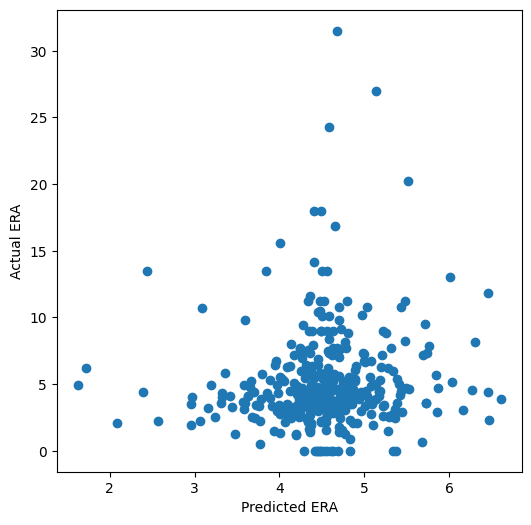

In [19]:
fig, ax1 = plt.subplots(1, 1, figsize = (6, 6))
ax1.scatter(pitching27pred['ERA'], pitch27YTest['ERA'])
ax1.set_xlabel('Predicted ERA')
ax1.set_ylabel('Actual ERA')
x = pitching27pred['ERA'].reset_index(drop=True)
y = pitch27YTest['ERA'].reset_index(drop=True)
weights = pitch27YTest['TBF'].reset_index(drop=True)
corr = weighted_corr(x, y, weights)
print(corr)

0.2693842219150331


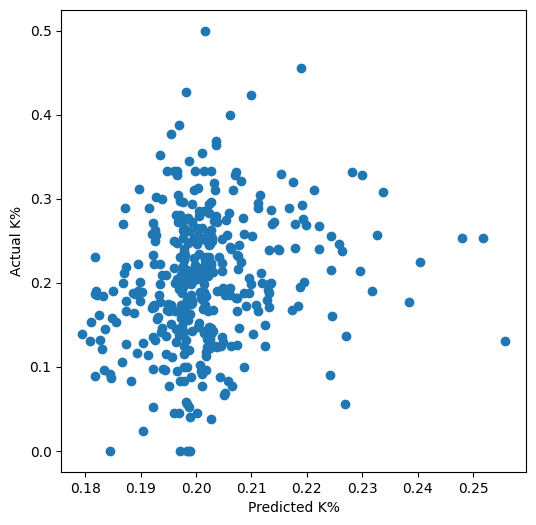

In [20]:
fig, ax1 = plt.subplots(1, 1, figsize = (6, 6))
ax1.scatter(pitching27pred['K%'], pitch27YTest['K%'])
x = pitching27pred['K%'].reset_index(drop=True)
y = pitch27YTest['K%'].reset_index(drop=True)
ax1.set_xlabel('Predicted K%')
ax1.set_ylabel('Actual K%')
weights = pitch27YTest['TBF'].reset_index(drop=True)
corr = weighted_corr(x, y, weights)
print(corr)

0.03286694091024311


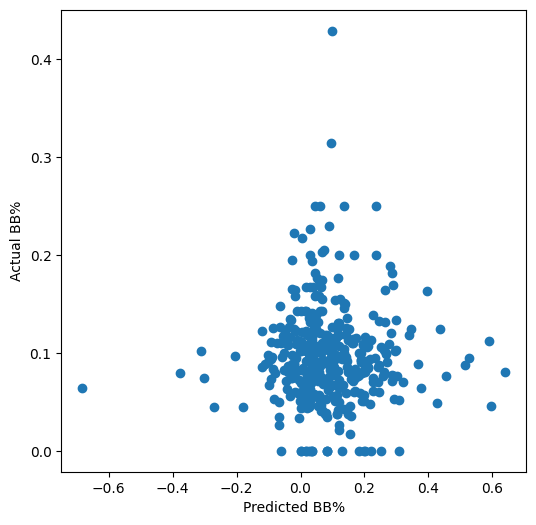

In [21]:
fig, ax1 = plt.subplots(1, 1, figsize = (6, 6))
ax1.scatter(pitching27pred['BB%'], pitch27YTest['BB%'])
ax1.set_xlabel('Predicted BB%')
ax1.set_ylabel('Actual BB%')
x = pitching27pred['BB%'].reset_index(drop=True)
y = pitch27YTest['BB%'].reset_index(drop=True)
weights = pitch27YTest['TBF'].reset_index(drop=True)
corr = weighted_corr(x, y, weights)
print(corr)

-0.010256056329555431


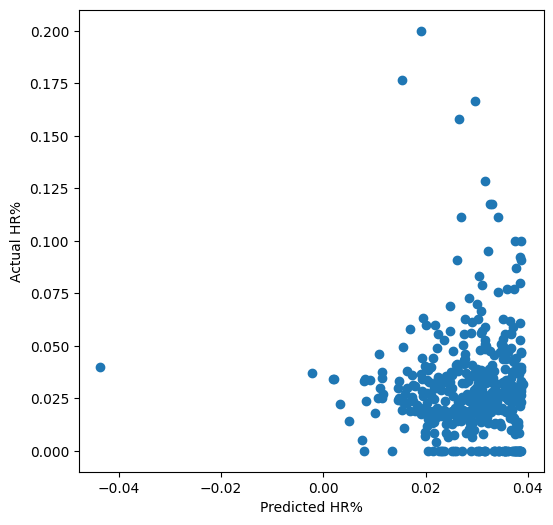

In [22]:
fig, ax1 = plt.subplots(1, 1, figsize = (6, 6))
ax1.scatter(pitching27pred['HR%'], pitch27YTest['HR%'])
ax1.set_xlabel('Predicted HR%')
ax1.set_ylabel('Actual HR%')
x = pitching27pred['HR%'].reset_index(drop=True)
y = pitch27YTest['HR%'].reset_index(drop=True)
weights = pitch27YTest['TBF'].reset_index(drop=True)
corr = weighted_corr(x, y, weights)
print(corr)

-0.07533840190019118


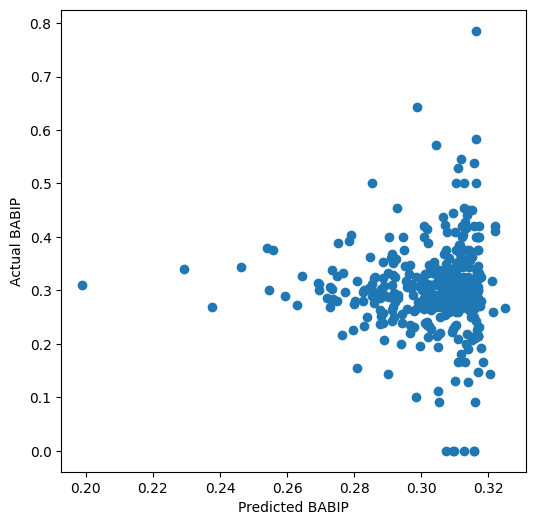

In [23]:
fig, ax1 = plt.subplots(1, 1, figsize = (6, 6))
ax1.scatter(pitching27pred['BABIP'], pitch27YTest['BABIP'])
ax1.set_xlabel('Predicted BABIP')
ax1.set_ylabel('Actual BABIP')
x = pitching27pred['BABIP'].reset_index(drop=True)
y = pitch27YTest['BABIP'].reset_index(drop=True)
weights = pitch27YTest['TBF'].reset_index(drop=True)
corr = weighted_corr(x, y, weights)
print(corr)

0.1319463945167271


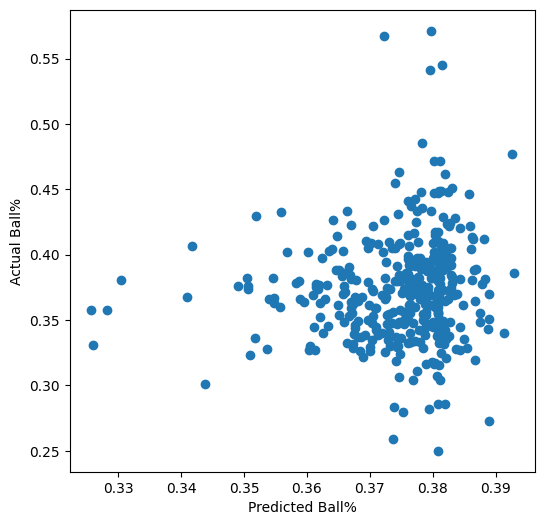

In [24]:
fig, ax1 = plt.subplots(1, 1, figsize = (6, 6))
ax1.scatter(pitching27pred['Ball%'], pitch27YTest['Ball%'])
ax1.set_xlabel('Predicted Ball%')
ax1.set_ylabel('Actual Ball%')
x = pitching27pred['Ball%'].reset_index(drop=True)
y = pitch27YTest['Ball%'].reset_index(drop=True)
weights = pitch27YTest['TBF'].reset_index(drop=True)
corr = weighted_corr(x, y, weights)
print(corr)

In [25]:
pitchpipeline24 = make_pipeline(StandardScaler(), mlp_reg)

pitchpipeline24.fit(pitch24XTrain, pitch24YTrain)

NameError: name 'pitch24XTrain' is not defined

In [ ]:
pitching24pred = pitchpipeline24.predict(pitch24XTest)
pitching24pred = pd.DataFrame(pitching24pred)
pitching24pred.columns = (['ERA', 'TBF', 'BABIP', 'K%', 'BB%', 'H%', 'Ball%', 'Strike%', 'HR%'])

0.126074393826106


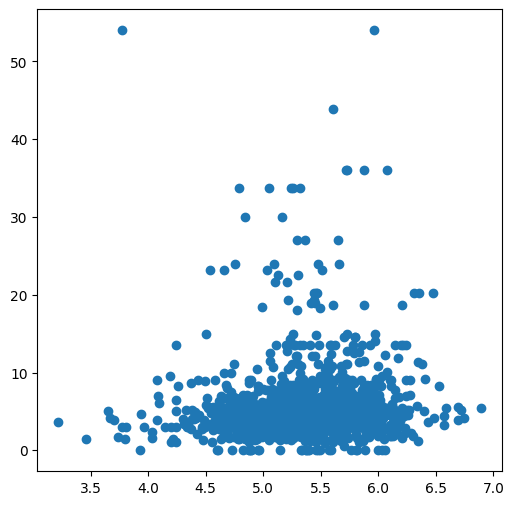

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (6, 6))
ax1.scatter(pitching24pred['ERA'], pitch24YTest['ERA24'])
x = pitching24pred['ERA'].reset_index(drop=True)
y = pitch24YTest['ERA24'].reset_index(drop=True)
weights = pitch24YTest['TBF24'].reset_index(drop=True)
corr = weighted_corr(x, y, weights)
print(corr)

0.08323147320438162


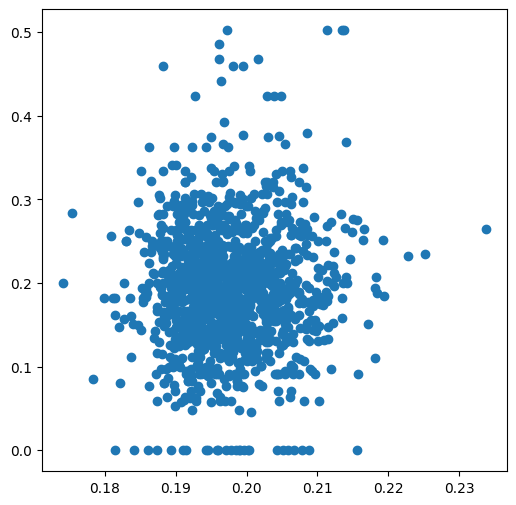

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (6, 6))
ax1.scatter(pitching24pred['K%'], pitch24YTest['K%24'])
x = pitching24pred['K%'].reset_index(drop=True)
y = pitch24YTest['K%24'].reset_index(drop=True)
weights = pitch24YTest['TBF24'].reset_index(drop=True)
corr = weighted_corr(x, y, weights)
print(corr)

0.13875651455423502


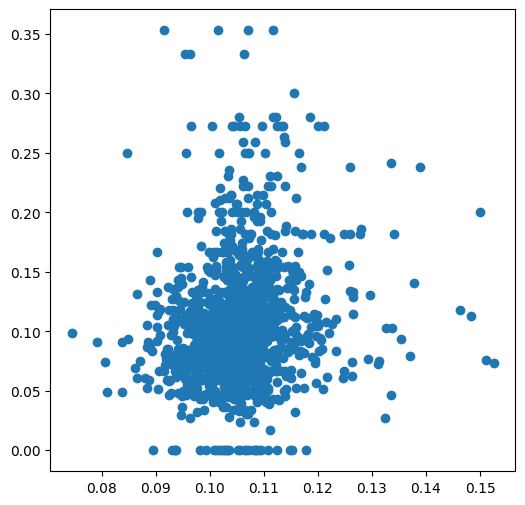

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (6, 6))
ax1.scatter(pitching24pred['BB%'], pitch24YTest['BB%24'])
x = pitching24pred['BB%'].reset_index(drop=True)
y = pitch24YTest['BB%24'].reset_index(drop=True)
weights = pitch24YTest['TBF24'].reset_index(drop=True)
corr = weighted_corr(x, y, weights)
print(corr)